In [1]:
import polars as pl
import numpy as np
from typing import List, Dict

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and not col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        log1p_cols: List[str] = None,
        exclude_cols: List[str] = None,
) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']
        
    if log1p_cols is None:
        log1p_cols = []

    for col in log1p_cols:
        if col in df_to_transforms.columns:
            df_to_transforms = df_to_transforms.with_columns([
                pl.col(col).clip(lower_bound=0.0).log1p().alias(col)
            ])
            
    # base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    # single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    # multi_exprs = batch_apply_multi_exprs(base_cols)

    # exprs = single_exprs + multi_exprs
    # return df_to_transforms.with_columns(exprs)
    return df_to_transforms



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm
import gc

def split_df_by_month(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = origin_input_df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        origin_input_df.filter(pl.col("month_start") == mt).drop("month_start")
        for mt in unique_months["month_start"]
    ]

    return monthly_dfs

    
def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 500000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()
    del df_to_clean
    gc.collect()
    print("converted")
    
    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)

    if verbose:
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
    
    del pd_df
    gc.collect()    
    
    pd_df_clean = pd_df_cleaned.dropna()

    if verbose:
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    del pd_df_cleaned
    gc.collect()   
    
    pl_df_clean = pl.from_pandas(pd_df_clean)

    del pd_df_clean
    gc.collect()
    
    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        # .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_tanh_normalize(
    rollin_df: pl.DataFrame,
    window: int,
    rolling_mean_window: int,
) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_tanh_expr(
            col=column,
            scaled_col=f"{column}_zscaled",
            window=window,
            rolling_mean_window=rolling_mean_window,
        ) for column in columns_to_normalize
    ]) 

def z_score_tanh_expr(
    col: str,
    scaled_col: str,
    window: int,
    rolling_mean_window: int,
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window, min_samples=1)
    std_expr = pl.col(col).rolling_std(window, min_samples=1).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-3.0, 3.0)
        .tanh()
        .rolling_mean(rolling_mean_window, min_samples=1)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
import polars as pl

def fast_build_long_cross_sections(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    long_df = pl.concat(list(symbol_dfs.values()))

    return long_df.sort("timestamp")


In [4]:
def process_single_symbol(
    symbol: str,
    threshold: str,
    feat_cal_window: str,
    data_dir: str = "C:/quant/data/binance_resampled_data/",
    feat_trans_window: int = 350,
    feat_trans_lags: list[int] = [5, 10, 20, 50, 100, 150, 200],
    feat_norm_window: int = 500,
    feat_norm_rolling_mean_window: int = 10,
) -> pl.DataFrame:
    symbol.upper()
    
    file = f"{symbol}_factors_threshold{threshold}_rolling{feat_cal_window}.csv"
    path = data_dir + file
    df = pl.read_csv(path)

    # 删掉不需要的列
    df = df.drop([
        "top_acc_longShortRatio", "top_pos_longShortRatio", "acc_longShortRatio"
    ])

    # 对部分列进行 log1p + lag 变换
    cols_to_log1p = [
        "far_bid_price", "far_ask_price",
        "best_bid_price", "best_ask_price",
        "sum_buy_sz", "sum_sell_sz",
        "ts_duration", "real_bid_amount_sum", "real_ask_amount_sum",
    ]
    df = batch_apply_transforms(df, feat_trans_window, feat_trans_lags, cols_to_log1p)

    # rolling z-score + tanh 归一
    df = rolling_z_tanh_normalize(df, feat_norm_window, feat_norm_rolling_mean_window)

    # 去掉 std=0 的列
    stds = df.select([
        pl.col(col).std().alias(col)
        for col in df.columns
        if df[col].dtype in (pl.Float64, pl.Int64)
    ])
    zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
    df = df.drop(zero_std_cols)

    return df


In [5]:

def filter_valid_cross_sections(long_df: pl.DataFrame, num_symbols: int) -> pl.DataFrame:
    valid_ts = (
        long_df
        .filter(pl.col("px").is_not_null())
        .group_by("timestamp")
        .agg(pl.len().alias("len"))
        .filter(pl.col("len") == num_symbols)
        .select("timestamp")
    )
    return long_df.join(valid_ts, on="timestamp", how="inner")


def build_long_cross_sections_fast(symbol_dfs: dict[str, pl.DataFrame]) -> pl.DataFrame:
    # 1. 获取所有币种的所有时间戳，合并去重，得到全局时间轴 timeline
    all_timestamps = (
        pl.concat(
            [df.select("timestamp").unique() for df in symbol_dfs.values()]
        )
        .unique()
        .sort("timestamp")
    )

    result_dfs = []

    for symbol, df in symbol_dfs.items():
        # 确保 df 按时间戳排序
        df_sorted = df.sort("timestamp")
        # 2. 用 timeline 左连接（asof join）当前币种数据，找最近小于等于时间戳的行
        joined = all_timestamps.join_asof(
            df_sorted,
            on="timestamp",
            strategy="backward"  # 小于等于左表时间戳的最近一条右表数据
        )
        # 3. 补充 symbol 列（如果df本身有，确认无误）
        # 如果原始 df 有 symbol，这里确认 symbol 是正确的
        joined = joined.with_columns(pl.lit(symbol).alias("symbol"))
        result_dfs.append(joined)

    long_df = pl.concat(result_dfs).sort(["timestamp", "symbol"])
    clean_df = filter_valid_cross_sections(long_df, len(symbol_dfs))


    return clean_df

In [6]:
from collections import defaultdict

def process_all_symbols(params_dict):
    symbol_dfs = {}
    for sym, param in params_dict.items():
        df = process_single_symbol(
            symbol=sym,
            threshold=param.get("threshold", "0.002"),
            feat_cal_window=param.get("feat_cal_window", "2000"),
            feat_trans_window=param.get("feat_trans_window", 350),
            feat_norm_window=param.get("feat_norm_window", 500),
            feat_norm_rolling_mean_window=param.get("feat_norm_rolling_mean_window", 10),
        )
        df = df.with_columns(pl.lit(sym).alias("symbol"))
        symbol_dfs[sym] = df
        
    return symbol_dfs

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs:", len(weekly_dataframes))

feat_cal_window = 5000
feat_trans_window = 2000
feat_norm_window = 2000
feat_norm_rolling_mean_window = 500

symbol_params = {
    "btcusdt": {
        "threshold": "0.001",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "bnbusdt": {
        "threshold": "0.001",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "ethusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "dogeusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "tonusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    # "filusdt": {
    #     "threshold": "0.002",
    #     "feat_cal_window": str(feat_cal_window),
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    "ltcusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "avaxusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "atomusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "solusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "xrpusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "uniusdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    "adausdt": {
        "threshold": "0.002",
        "feat_cal_window": str(feat_cal_window),
        "feat_trans_window": feat_trans_window,
        "feat_norm_window": feat_norm_window,
        "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    },
    # "linkusdt": {
    #     "threshold": "0.002",
    #     "feat_cal_window": str(feat_cal_window),
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    # "dotusdt": {
    #     "threshold": "0.002",
    #     "feat_cal_window": str(feat_cal_window),
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
    # "sandusdt": {
    #     "threshold": "0.002",
    #     "feat_cal_window": str(feat_cal_window),
    #     "feat_trans_window": feat_trans_window,
    #     "feat_norm_window": feat_norm_window,
    #     "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
    # },
}

symbol_dfs = process_all_symbols(symbol_params)
long_df = build_long_cross_sections_fast(symbol_dfs)


In [7]:
del symbol_dfs  # 删除变量引用
gc.collect()

10

In [8]:
print(long_df)

shape: (6_941_076, 217)
┌───────────────┬─────────┬────────────┬─────────────┬───┬─────────────────────────┬─────────────────────────┬─────────────────────────┬──────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_order_sentimen ┆ z_factor_oi_momentum_pu ┆ z_factor_oi_momentum_lo ┆ symbol   │
│ ---           ┆ ---     ┆ ---        ┆ ---         ┆   ┆ t_diver…                ┆ nch_zsc…                ┆ ng_term…                ┆ ---      │
│ i64           ┆ f64     ┆ f64        ┆ f64         ┆   ┆ ---                     ┆ ---                     ┆ ---                     ┆ str      │
│               ┆         ┆            ┆             ┆   ┆ f64                     ┆ f64                     ┆ f64                     ┆          │
╞═══════════════╪═════════╪════════════╪═════════════╪═══╪═════════════════════════╪═════════════════════════╪═════════════════════════╪══════════╡
│ 1743984084668 ┆ 0.5732  ┆ 13.80055   ┆ 13.421752   ┆ … ┆ -0.304429               ┆ -0.

In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.callbacks import Callback
from pytorch_tabnet.callbacks import History
from pytorch_tabnet.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
N = 3000
target_col = f"future_return_{N}"
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']


In [11]:
le_symbol = LabelEncoder()
long_df = long_df.with_columns(pl.col('symbol').str.to_uppercase())

all_symbols = set()
all_symbols.update(long_df["symbol"].unique())
le_symbol.fit(sorted(list(all_symbols)))

symbol_encoded = le_symbol.transform(long_df['symbol'].to_list())
long_df = long_df.with_columns([pl.Series('enc_cat_symbol', symbol_encoded)])

symbol_to_id = dict(zip(le_symbol.classes_, le_symbol.transform(le_symbol.classes_)))
id_to_symbol = {v: k for k, v in symbol_to_id.items()}

# 加 row_nr
long_temp_df = long_df.with_row_index(name="row_nr")
del long_df
gc.collect() 

20

In [12]:
df_with_future = (
    long_temp_df.sort(["symbol", "timestamp"])
    .group_by("symbol", maintain_order=True)
    .map_groups(lambda g: g.with_columns([
        pl.col("px").shift(-N).alias("px_future"),
        (pl.col("px").shift(-N) / pl.col("px")).log().alias(f"future_return_{N}")
    ]))
    .sort("row_nr")
    .drop("row_nr")
)


In [13]:
time_series_feature_cols = [
    col for col in df_with_future.columns
    if (
        (col.endswith("_cs") or col.endswith("_zscaled"))
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and not col.startswith("px_future")
        and col != "px"
    )
]

In [14]:
# 在 long format 下，按 timestamp 做截面标准化 & 排序
df_with_future = df_with_future.with_columns([
    # 截面 z-score
    ((pl.col(c) - pl.col(c).mean().over("timestamp")) /
     pl.when(pl.col(c).std().over("timestamp") > 1e-9)
       .then(pl.col(c).std().over("timestamp"))
       .otherwise(1)
    ).alias(f"{c}_zscore_cs")
    for c in time_series_feature_cols
])# + [
#     # 截面 rank（归一化到 [0,1]）
#     (pl.col(c).rank("average").over("timestamp") /
#      pl.len().over("timestamp")).alias(f"{c}_rank_cs")
#     for c in time_series_feature_cols
# ])

In [15]:
# 把 enc_cat_symbol 移到最后一列
cols = [c for c in df_with_future.columns if c != "enc_cat_symbol"] + ["enc_cat_symbol"]
df_with_future = df_with_future.select(cols)

In [16]:
feature_cols = [
    col for col in df_with_future.columns
    if (
        (col.endswith("_cs") or col.endswith("_zscaled") or col == "enc_cat_symbol")
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and not col.startswith("px_future")
        and col != "px"
    )
]

In [17]:
df_with_future = clean_df_drop_nulls(df_with_future)
weekly_dataframes = split_df_by_month(df_with_future)  # 只拿 list

converted
各列空值数量：
px_future             36000
future_return_3000    36000
dtype: int64
删除空值超过 500000 的列：[]
删除列后，DataFrame形状：(6941076, 319)
删除空值行后，DataFrame形状：(6905076, 319)


In [18]:
print(symbol_to_id) 
print(id_to_symbol)

{np.str_('ADAUSDT'): np.int64(0), np.str_('ATOMUSDT'): np.int64(1), np.str_('AVAXUSDT'): np.int64(2), np.str_('BNBUSDT'): np.int64(3), np.str_('BTCUSDT'): np.int64(4), np.str_('DOGEUSDT'): np.int64(5), np.str_('ETHUSDT'): np.int64(6), np.str_('LTCUSDT'): np.int64(7), np.str_('SOLUSDT'): np.int64(8), np.str_('TONUSDT'): np.int64(9), np.str_('UNIUSDT'): np.int64(10), np.str_('XRPUSDT'): np.int64(11)}
{np.int64(0): np.str_('ADAUSDT'), np.int64(1): np.str_('ATOMUSDT'), np.int64(2): np.str_('AVAXUSDT'), np.int64(3): np.str_('BNBUSDT'), np.int64(4): np.str_('BTCUSDT'), np.int64(5): np.str_('DOGEUSDT'), np.int64(6): np.str_('ETHUSDT'), np.int64(7): np.str_('LTCUSDT'), np.int64(8): np.str_('SOLUSDT'), np.int64(9): np.str_('TONUSDT'), np.int64(10): np.str_('UNIUSDT'), np.int64(11): np.str_('XRPUSDT')}


In [19]:
print(weekly_dataframes[-1])

shape: (405_336, 320)
┌───────────────┬──────────┬────────────┬─────────────┬───┬───────────────────────────┬───────────────────────────┬────────────────┬──────────────┐
│ timestamp     ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_momentum_punc ┆ z_factor_oi_momentum_long ┆ enc_cat_symbol ┆ timestamp_dt │
│ ---           ┆ ---      ┆ ---        ┆ ---         ┆   ┆ h_zsc…                    ┆ _term…                    ┆ ---            ┆ ---          │
│ i64           ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                       ┆ ---                       ┆ i64            ┆ datetime[ms] │
│               ┆          ┆            ┆             ┆   ┆ f64                       ┆ f64                       ┆                ┆              │
╞═══════════════╪══════════╪════════════╪═════════════╪═══╪═══════════════════════════╪═══════════════════════════╪════════════════╪══════════════╡
│ 1754006408428 ┆ 0.7385   ┆ 13.200294  ┆ 13.292008   ┆ … ┆ -0.993205                 ┆ -1

In [20]:
# 用第一个 df 定义 feature_cols
sample_df = weekly_dataframes[0]

cat_idxs = [feature_cols.index('enc_cat_symbol')]
cat_dims = [sample_df.select('enc_cat_symbol').n_unique()]
cat_emb_dim = 8
print(len(feature_cols), cat_idxs, cat_dims)

199 [198] [12]


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section(symbols, y_true, y_binary, y_pred_prob, px, alpha=1.0):
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    width = 0.2

    # 真实未来收益（连续）
    ax1.bar(x - width, y_true, width=width, label='Future Return', alpha=0.6)
    ax1.set_ylabel('Future Return')

    # 价格线
    ax2 = ax1.twinx()
    ax2.plot(x, px, label='Price', color='tab:blue', marker='o')
    ax2.set_ylabel('Price')

    # 分类标签（二分类）
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.scatter(x, y_binary, label='GMM Label', color='tab:orange', marker='x')
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_ylabel('Binary Label')

    # 预测概率
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    ax4.plot(x, y_pred_prob, label='Predicted Prob', color='tab:green', marker='^')
    ax4.set_ylim(-0.05, 1.05)
    ax4.set_ylabel('Predicted Probability')

    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45)
    ax1.set_xlabel('Symbols')

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.title("Cross-Section Comparison at One Timestamp")
    plt.tight_layout()
    plt.show()


In [22]:
class MinEpochsEarlyStopping(EarlyStopping):
    def __init__(self, early_stopping_metric, patience, min_epochs=5, is_maximize=False, tol=0.0):
        super().__init__(
            early_stopping_metric=early_stopping_metric,
            patience=patience,
            is_maximize=is_maximize,
            tol=tol
        )
        self.min_epochs = min_epochs
        self._callback_reset_flag = False

    def on_epoch_end(self, epoch, logs):
        # 在 min_epochs 之前，不触发早停逻辑
        if epoch < self.min_epochs:
            return

        self.stopped_epoch = epoch
        
        # 调用父类逻辑继续正常早停检查
        super().on_epoch_end(max(epoch, self.min_epochs), logs)
        
        # 第一次达到 min_epochs 时重置 baseline
        if not self._callback_reset_flag:
            print(f"[Check] Current best_epoch={self.best_epoch}, best_loss={self.best_loss:.6f}")

            if self.early_stopping_metric not in logs:
                raise KeyError(f"Metric '{self.early_stopping_metric}' not found in logs keys={list(logs.keys())}")
            
            self.best_loss = logs[self.early_stopping_metric]
            self.best_epoch = epoch

            # preventing double log bug
            self._callback_reset_flag = True
            print(f"[MinEpochsEarlyStopping] Reset best_score at epoch {epoch} to {self.best_loss:.6f}")

        print(f"[DEBUG] After super(): best_loss={self.best_loss:.6f}, best_epoch={self.best_epoch}, wait={self.wait}")


In [112]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

tabnet = None

all_preds = []  # 放到 for 循环外

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]

    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)
    
    def process_df_np(df):
        df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px'])
        X = df.select(feature_cols).to_numpy()  # Polars DataFrame 转 numpy ndarray
        y = df.select(target_col).to_numpy().reshape(-1, 1)
        px = df.select('px').to_numpy()
        ts = df.select('timestamp').to_numpy()
        symbol_enc = df.select("enc_cat_symbol")
        return X, y, px, ts, symbol_enc

    X_train, y_train, px_train, ts_train, sb_train = process_df_np(train_df)
    X_val, y_val, px_val, ts_val, sb_val = process_df_np(val_df)
    X_test, y_test, px_test, ts_test, sb_test = process_df_np(test_df)


    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    

    params = {
        # 模型结构参数
        "n_d": 8,                      # 决策输出维度
        "n_a": 8,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": cat_idxs,               # 类别特征的列索引
        "cat_dims": cat_dims,               # 每个类别特征的类别数
        "cat_emb_dim": cat_emb_dim,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-5,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "sparsemax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 5e-5},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 2,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['mae'],
        "max_epochs": 20,
        # "patience": 5,
        "batch_size": 2048,
        "virtual_batch_size": 512,
        "compute_importance": False,
    }

    my_early_stopping = MinEpochsEarlyStopping(
        early_stopping_metric='val_0_mae',
        patience=3,
        min_epochs=3,
    )
    
    tabnet = TabNetRegressor(**params )
    tabnet.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[my_early_stopping], # 使用你的自定义回调
        **init_fit_params,
    )

    y_pred = tabnet.predict(X_test).squeeze()
    print(ts_test.shape, y_test.shape, y_pred.shape, px_test.shape)

    print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
    current_window_results = {
        'timestamp': ts_test,
        'symbol_enc': sb_test, # 收集价格，回测时需要
        'true_label': y_test,
        'predicted_prob': y_pred,
        'px': px_test, # 收集价格，回测时需要
    }
    
    all_preds.append(current_window_results)



Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 00:01:24.668000 to 2025-06-30 23:59:17.300000
Val: 2025-07-01 00:02:56.222000 to 2025-07-31 23:59:40.161000
Test: 2025-08-01 00:00:08.428000 to 2025-08-08 03:14:42.410000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.27104 | val_0_mae: 0.20787 |  0:02:07s
epoch 2  | loss: 0.01738 | val_0_mae: 0.08127 |  0:06:24s
[Check] Current best_epoch=3, best_loss=0.054673
[MinEpochsEarlyStopping] Reset best_score at epoch 3 to 0.054673
[DEBUG] After super(): best_loss=0.054673, best_epoch=3, wait=1
epoch 4  | loss: 0.00353 | val_0_mae: 0.03889 |  0:10:38s
[DEBUG] After super(): best_loss=0.038891, best_epoch=4, wait=1
[DEBUG] After super(): best_loss=0.030789, best_epoch=5, wait=1
epoch 6  | loss: 0.00127 | val_0_mae: 0.02717 |  0:14:56s
[DEBUG] After super(): best_loss=0.027173, best_epoch=6, wait=1
[DEBUG] After super(): best_loss=0.025825, best_epoch=7, wait=1
epoch 8  | loss: 0.00097 | val_0_mae: 0.02537 |  0:19:27s
[DEBUG] After super(): best_loss=0.025374, best_epoch=8, wait=1
[DEBUG] After super(): best_loss=0.025337, best_epoch=9, wait=1
epoch 10 | loss: 0.00089 | val_0_mae: 0.02549 |  0:23:50s
[DEBUG] After super(): best_loss=0.025337, best_epoch=9, wait=2
[DEBUG] After super(): bes

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


(405336, 1) (405336, 1) (405336,) (405336, 1)
MSE: 0.001077
MAE: 0.024983


In [113]:
all_preds

[{'timestamp': array([[1754006408428],
         [1754006408428],
         [1754006408428],
         ...,
         [1754622882410],
         [1754622882410],
         [1754622882410]]),
  'symbol_enc': shape: (405_336, 1)
  ┌────────────────┐
  │ enc_cat_symbol │
  │ ---            │
  │ i64            │
  ╞════════════════╡
  │ 0              │
  │ 1              │
  │ 2              │
  │ 3              │
  │ 4              │
  │ …              │
  │ 7              │
  │ 8              │
  │ 9              │
  │ 10             │
  │ 11             │
  └────────────────┘,
  'true_label': array([[-0.03066164],
         [-0.01631123],
         [-0.02893258],
         ...,
         [ 0.00757602],
         [ 0.03874599],
         [-0.02380098]]),
  'predicted_prob': array([ 0.00312492,  0.00090541,  0.00238355, ...,  0.00137009,
         -0.00134729, -0.0114124 ], dtype=float32),
  'px': array([[ 0.7385],
         [ 4.203 ],
         [22.477 ],
         ...,
         [ 3.3137],
         [1

In [114]:
print(f"all_preds length: {len(all_preds)}")



all_preds length: 1


In [115]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cross_section_comparison(symbols, true_labels, pred_probs, prices, std_array=None, alpha=1):
    """
    symbols: list/array of symbol names或编码（横轴）
    true_labels: array，对应每个币种的真实标签
    pred_probs: array，对应每个币种的预测概率
    prices: array，对应每个币种的价格
    std_array: array，可选，价格的波动区间
    alpha: 标准差放大倍数
    """
    x = np.arange(len(symbols))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 真实标签（可以用点图）
    ax1.scatter(x, true_labels, label="True Label", color='tab:blue', marker='o', s=50, alpha=0.7)
    ax1.set_ylabel("True Label", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(min(true_labels)*1.1, max(true_labels)*1.1)

    # 预测概率
    ax2 = ax1.twinx()
    ax2.plot(x, pred_probs, label="Predicted Probability", color='tab:green', marker='x', linestyle='-', alpha=0.7)
    ax2.set_ylabel("Predicted Probability", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylim(0, 1)

    # 价格
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(x, prices, label="Price", color='tab:red', linestyle='--', alpha=0.7)

    # 价格区间带
    if std_array is not None:
        ax3.fill_between(x, prices - alpha * std_array, prices + alpha * std_array,
                         color='tab:red', alpha=0.15, label="Price ± std")

    ax3.set_ylabel("Price", color='tab:red')
    ax3.tick_params(axis='y', labelcolor='tab:red')

    # 横轴是币种名
    ax1.set_xticks(x)
    ax1.set_xticklabels(symbols, rotation=45, ha='right')

    plt.title("Cross-Sectional Comparison: True Label, Prediction & Price")
    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

    plt.tight_layout()
    plt.show()


In [116]:
import pandas as pd

df_list = []
for i, result in enumerate(all_preds):
    try:
        # 先处理 symbol_enc 转成 numpy array
        # 假设 result['symbol_enc'] 是 Polars DataFrame，列名是 'enc_cat_symbol'
        if hasattr(result['symbol_enc'], "to_pandas"):
            symbol_enc_array = result['symbol_enc'].to_pandas()['enc_cat_symbol'].values
        else:
            # 如果已经是 np.ndarray 或 list
            symbol_enc_array = result['symbol_enc']

        df = pd.DataFrame({
            'timestamp': result['timestamp'].squeeze(),  # (N,)
            'symbol_enc': symbol_enc_array.squeeze(),    # (N,)
            'true_label': result['true_label'].squeeze(),
            'predicted_prob': result['predicted_prob'].squeeze(),
            'px': result['px'].squeeze()
        })

        if df.empty:
            print(f"Warning: Empty dataframe at index {i}")
            continue
        df_list.append(df)
    except Exception as e:
        print(f"Error at index {i}: {e}")

full_df = pd.concat(df_list, ignore_index=True)
print(full_df.shape)
print(full_df.head())


(405336, 5)
       timestamp  symbol_enc  true_label  predicted_prob           px
0  1754006408428           0   -0.030662        0.003125       0.7385
1  1754006408428           1   -0.016311        0.000905       4.2030
2  1754006408428           2   -0.028933        0.002384      22.4770
3  1754006408428           3   -0.019628        0.000951     783.5900
4  1754006408428           4   -0.009079        0.010246  115757.2000


In [117]:
full_df

,timestamp,symbol_enc,true_label,predicted_prob,px
0,1754006408428,0,-0.030662,0.003125,0.7385
1,1754006408428,1,-0.016311,0.000905,4.2030
2,1754006408428,2,-0.028933,0.002384,22.4770
3,1754006408428,3,-0.019628,0.000951,783.5900
4,1754006408428,4,-0.009079,0.010246,115757.2000
...,...,...,...,...,...
405331,1754622882410,7,0.013745,0.013324,122.1100
405332,1754622882410,8,0.009957,0.006154,174.8800
405333,1754622882410,9,0.007576,0.001370,3.3137
405334,1754622882410,10,0.038746,-0.001347,10.4540


In [118]:
def bin_analysis(factor_name, weekly_dataframes, target_col, num_bins=5):
    bin_returns = [0.0] * num_bins
    bin_counts = [0] * num_bins

    for df in weekly_dataframes:
        if factor_name not in df.columns or target_col not in df.columns:
            continue

        sub_df = df.select([factor_name, target_col]).drop_nulls().to_pandas()
        if len(sub_df) < num_bins:
            continue

        sub_df["bin"] = pd.qcut(sub_df[factor_name], q=num_bins, labels=False, duplicates="drop")
        for i in range(num_bins):
            group = sub_df[sub_df["bin"] == i]
            if not group.empty:
                bin_returns[i] += group[target_col].mean()
                bin_counts[i] += 1

    avg_returns = [r / c if c > 0 else 0 for r, c in zip(bin_returns, bin_counts)]
    return avg_returns


In [119]:
import pandas as pd
from scipy.stats import spearmanr

def calc_ic_per_factor(weekly_dataframes, feature_cols, target_col):
    ic_records = []

    for feature in tqdm(feature_cols, unit="factor"):
        
        ic_list = []
        for df in weekly_dataframes:
            if feature not in df.columns or target_col not in df.columns:
                continue

            sub_df = df.select([feature, target_col]).drop_nulls().to_pandas()
            if len(sub_df) < 5:
                continue

            rank_ic, _ = spearmanr(sub_df[feature], sub_df[target_col])
            if pd.notna(rank_ic):
                ic_list.append(rank_ic)

        if ic_list:
            ic_mean = sum(ic_list) / len(ic_list)
            ic_std = pd.Series(ic_list).std()
            ic_ir = ic_mean / ic_std if ic_std > 1e-6 else 0
            ic_records.append({
                'factor': feature,
                'IC Mean': ic_mean,
                'IC Std': ic_std,
                'IC IR': ic_ir
            })

    ic_df = pd.DataFrame(ic_records).sort_values(by='IC IR', ascending=False)
    return ic_df


In [120]:
ic_df = calc_ic_per_factor(weekly_dataframes, feature_cols, target_col)
print("Top10 IC 因子：")
print(ic_df.head(10))

top_factors = ic_df.head(10)['factor'].tolist()
for factor in top_factors:
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    print(f"Factor: {factor}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [02:56<00:00,  1.13factor/s]


Top10 IC 因子：
                                            factor   IC Mean    IC Std  \
65           z_oi_dn_divergence_short_term_zscaled  0.045729  0.031834   
3                             bs_imbalance_zscaled  0.020912  0.016069   
68                        oi_di_short_term_zscaled  0.025370  0.020648   
154  oi_dn_divergence_short_term_zscaled_zscore_cs  0.034237  0.030900   
167             oi_di_short_term_zscaled_zscore_cs  0.017031  0.015621   
11                raw_factor_sentiment_net_zscaled  0.082038  0.087389   
55             oi_dn_divergence_short_term_zscaled  0.022974  0.025457   
110     raw_factor_sentiment_net_zscaled_zscore_cs  0.020479  0.023206   
147    lob_sz_imba_rol_mean_5000_zscaled_zscore_cs  0.025095  0.032113   
151   oi_up_divergence_long_term_zscaled_zscore_cs  0.018687  0.024625   

        IC IR  
65   1.436484  
3    1.301382  
68   1.228688  
154  1.108011  
167  1.090248  
11   0.938766  
55   0.902476  
110  0.882517  
147  0.781437  
151  0.75885

In [121]:
for _, row in ic_df.iterrows():
    factor = row['factor']
    ic = row['IC Mean']
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    print(f"Factor: {factor}, IC: {ic:.4f}")


Factor: z_oi_dn_divergence_short_term_zscaled, IC: 0.0457
Factor: bs_imbalance_zscaled, IC: 0.0209
Factor: oi_di_short_term_zscaled, IC: 0.0254
Factor: oi_dn_divergence_short_term_zscaled_zscore_cs, IC: 0.0342
Factor: oi_di_short_term_zscaled_zscore_cs, IC: 0.0170
Factor: raw_factor_sentiment_net_zscaled, IC: 0.0820
Factor: oi_dn_divergence_short_term_zscaled, IC: 0.0230
Factor: raw_factor_sentiment_net_zscaled_zscore_cs, IC: 0.0205
Factor: lob_sz_imba_rol_mean_5000_zscaled_zscore_cs, IC: 0.0251
Factor: oi_up_divergence_long_term_zscaled_zscore_cs, IC: 0.0187
Factor: z_factor_oi_trend_slope_zscaled_zscore_cs, IC: 0.0215
Factor: factor_oi_trend_slope_zscaled_zscore_cs, IC: 0.0241
Factor: ts_duration_zscaled_zscore_cs, IC: 0.0218
Factor: log1p_ts_velo_rol_mean_5000_zscaled_zscore_cs, IC: 0.0218
Factor: z_factor_oi_change_zscaled, IC: 0.0161
Factor: z_oi_dn_divergence_short_term_zscaled_zscore_cs, IC: 0.0431
Factor: enc_cat_symbol, IC: 0.0113
Factor: z_factor_oi_change_zscaled_zscore_cs, 

In [122]:
print(ic_df)
tail_factors = ic_df.tail(10)['factor'].tolist()
for factor in tail_factors:
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    print(f"Factor: {factor}")


                                            factor   IC Mean    IC Std  \
65           z_oi_dn_divergence_short_term_zscaled  0.045729  0.031834   
3                             bs_imbalance_zscaled  0.020912  0.016069   
68                        oi_di_short_term_zscaled  0.025370  0.020648   
154  oi_dn_divergence_short_term_zscaled_zscore_cs  0.034237  0.030900   
167             oi_di_short_term_zscaled_zscore_cs  0.017031  0.015621   
..                                             ...       ...       ...   
44                 z_bs_imba_rol_mean_5000_zscaled -0.027358  0.026057   
46                       z_oi_ls_term_diff_zscaled -0.046786  0.044422   
59                       z_oi_px_diff_5000_zscaled -0.050036  0.046810   
158            z_oi_px_diff_5000_zscaled_zscore_cs -0.021915  0.019665   
131       bs_ratio_rol_mean_5000_zscaled_zscore_cs -0.021049  0.015816   

        IC IR  
65   1.436484  
3    1.301382  
68   1.228688  
154  1.108011  
167  1.090248  
..        ...  

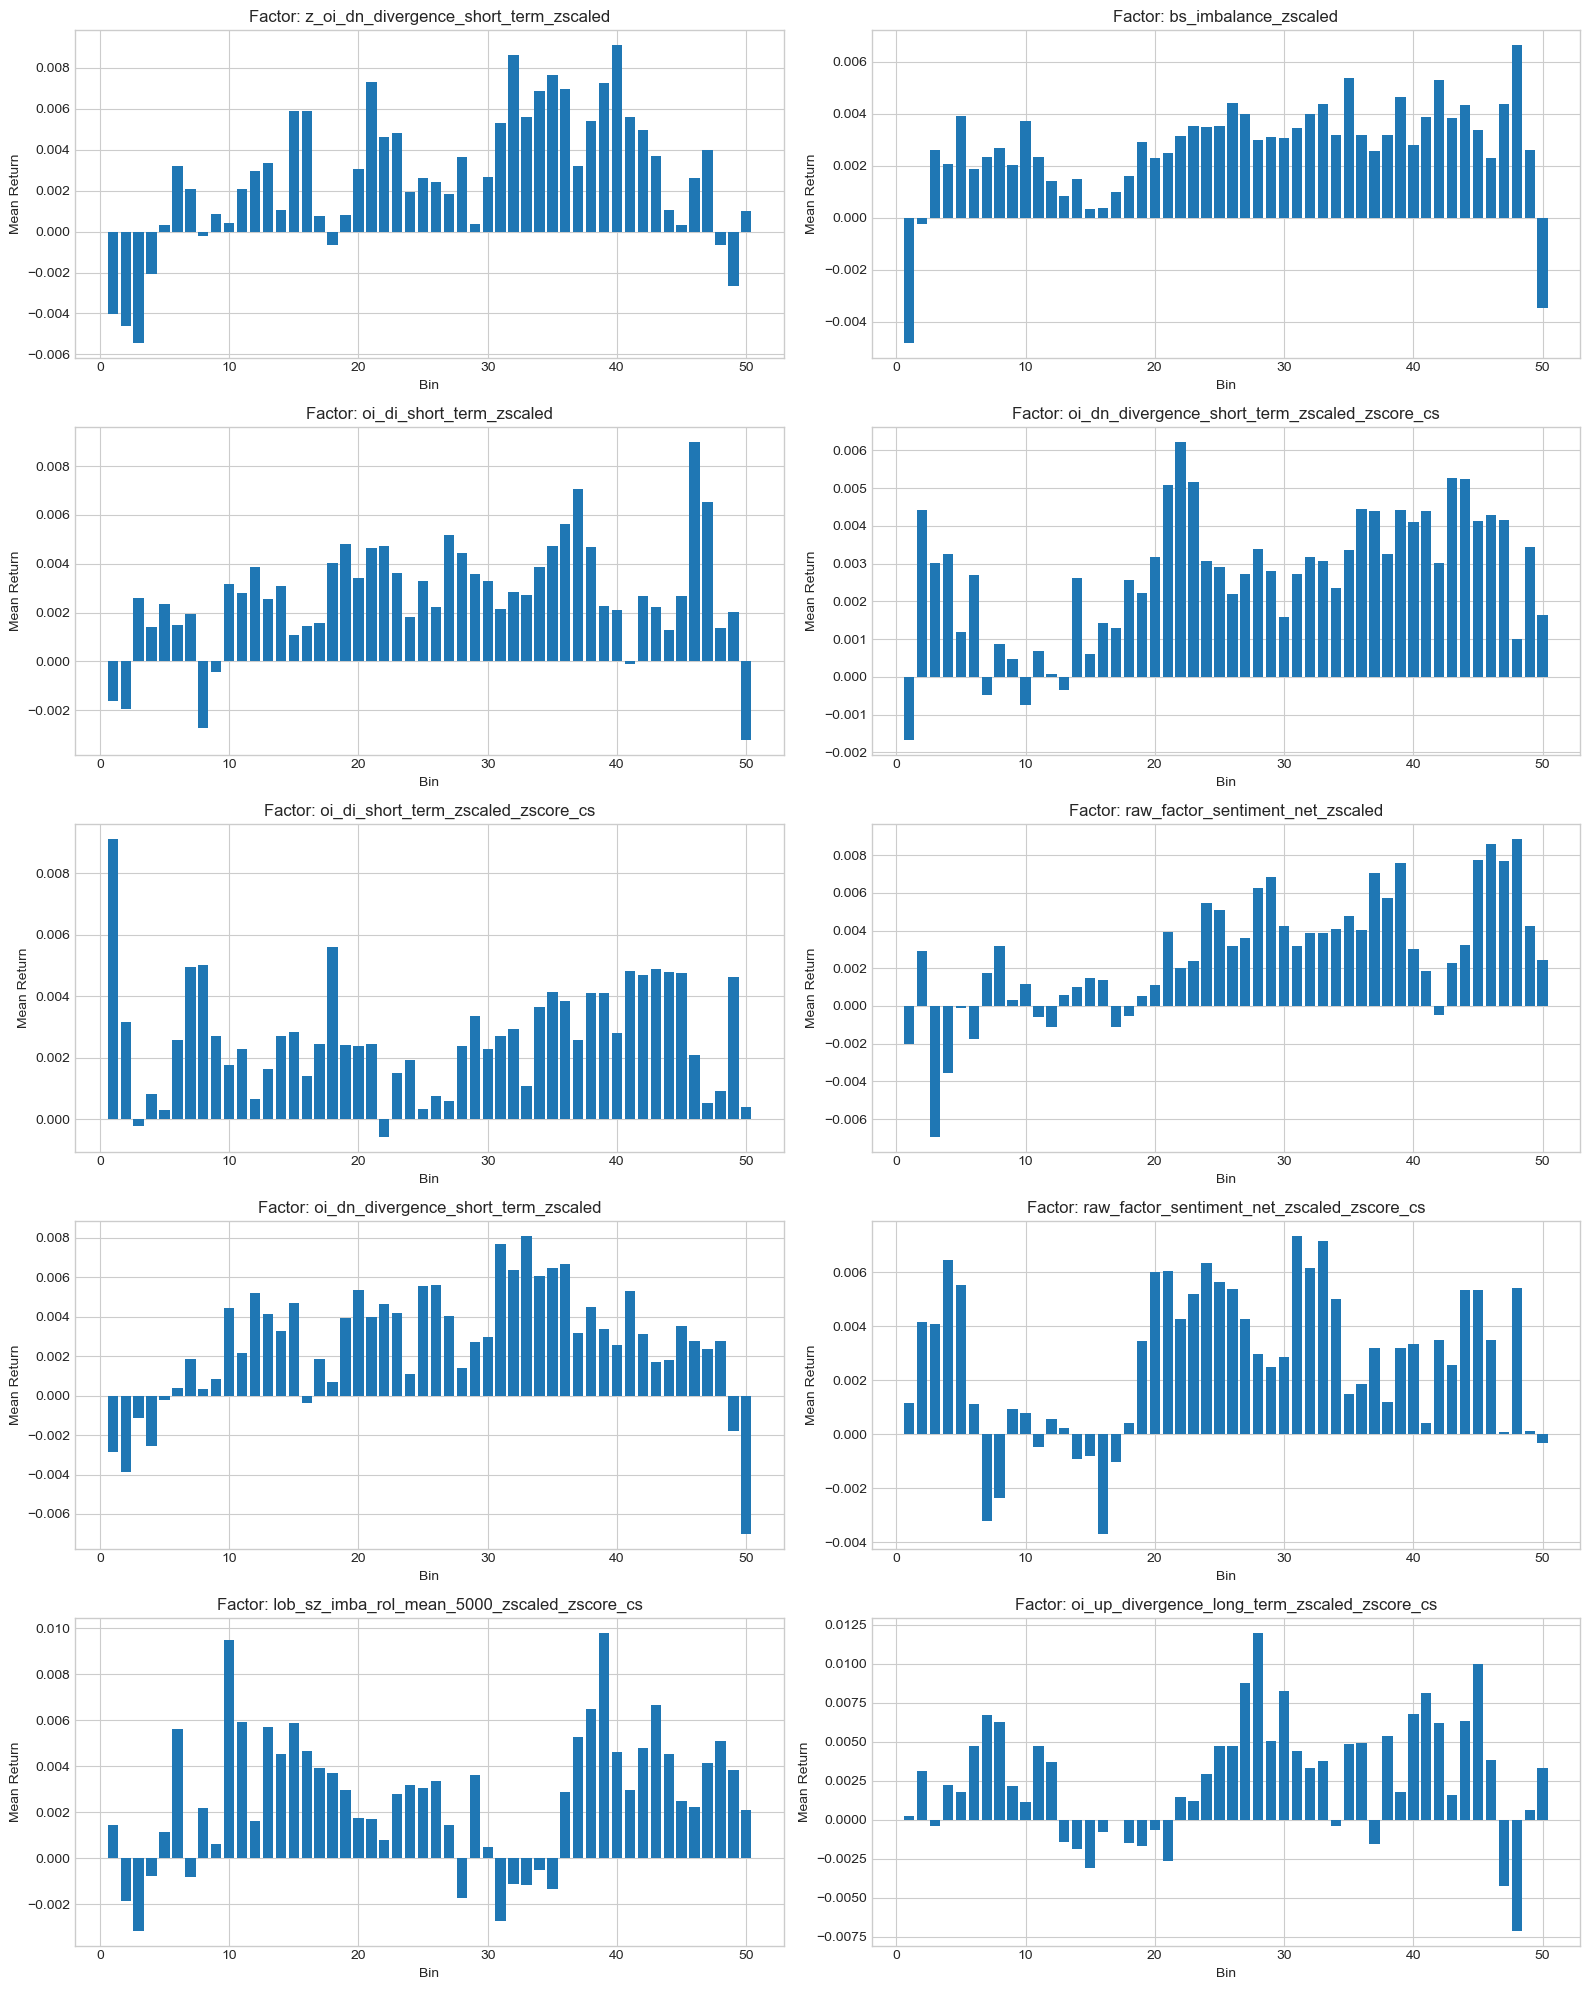

In [123]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, factor in enumerate(top_factors):
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    axes[i].bar(range(1, 1 + len(returns)), returns)
    axes[i].set_title(f"Factor: {factor}")
    axes[i].set_xlabel("Bin")
    axes[i].set_ylabel("Mean Return")

plt.tight_layout()
plt.show()


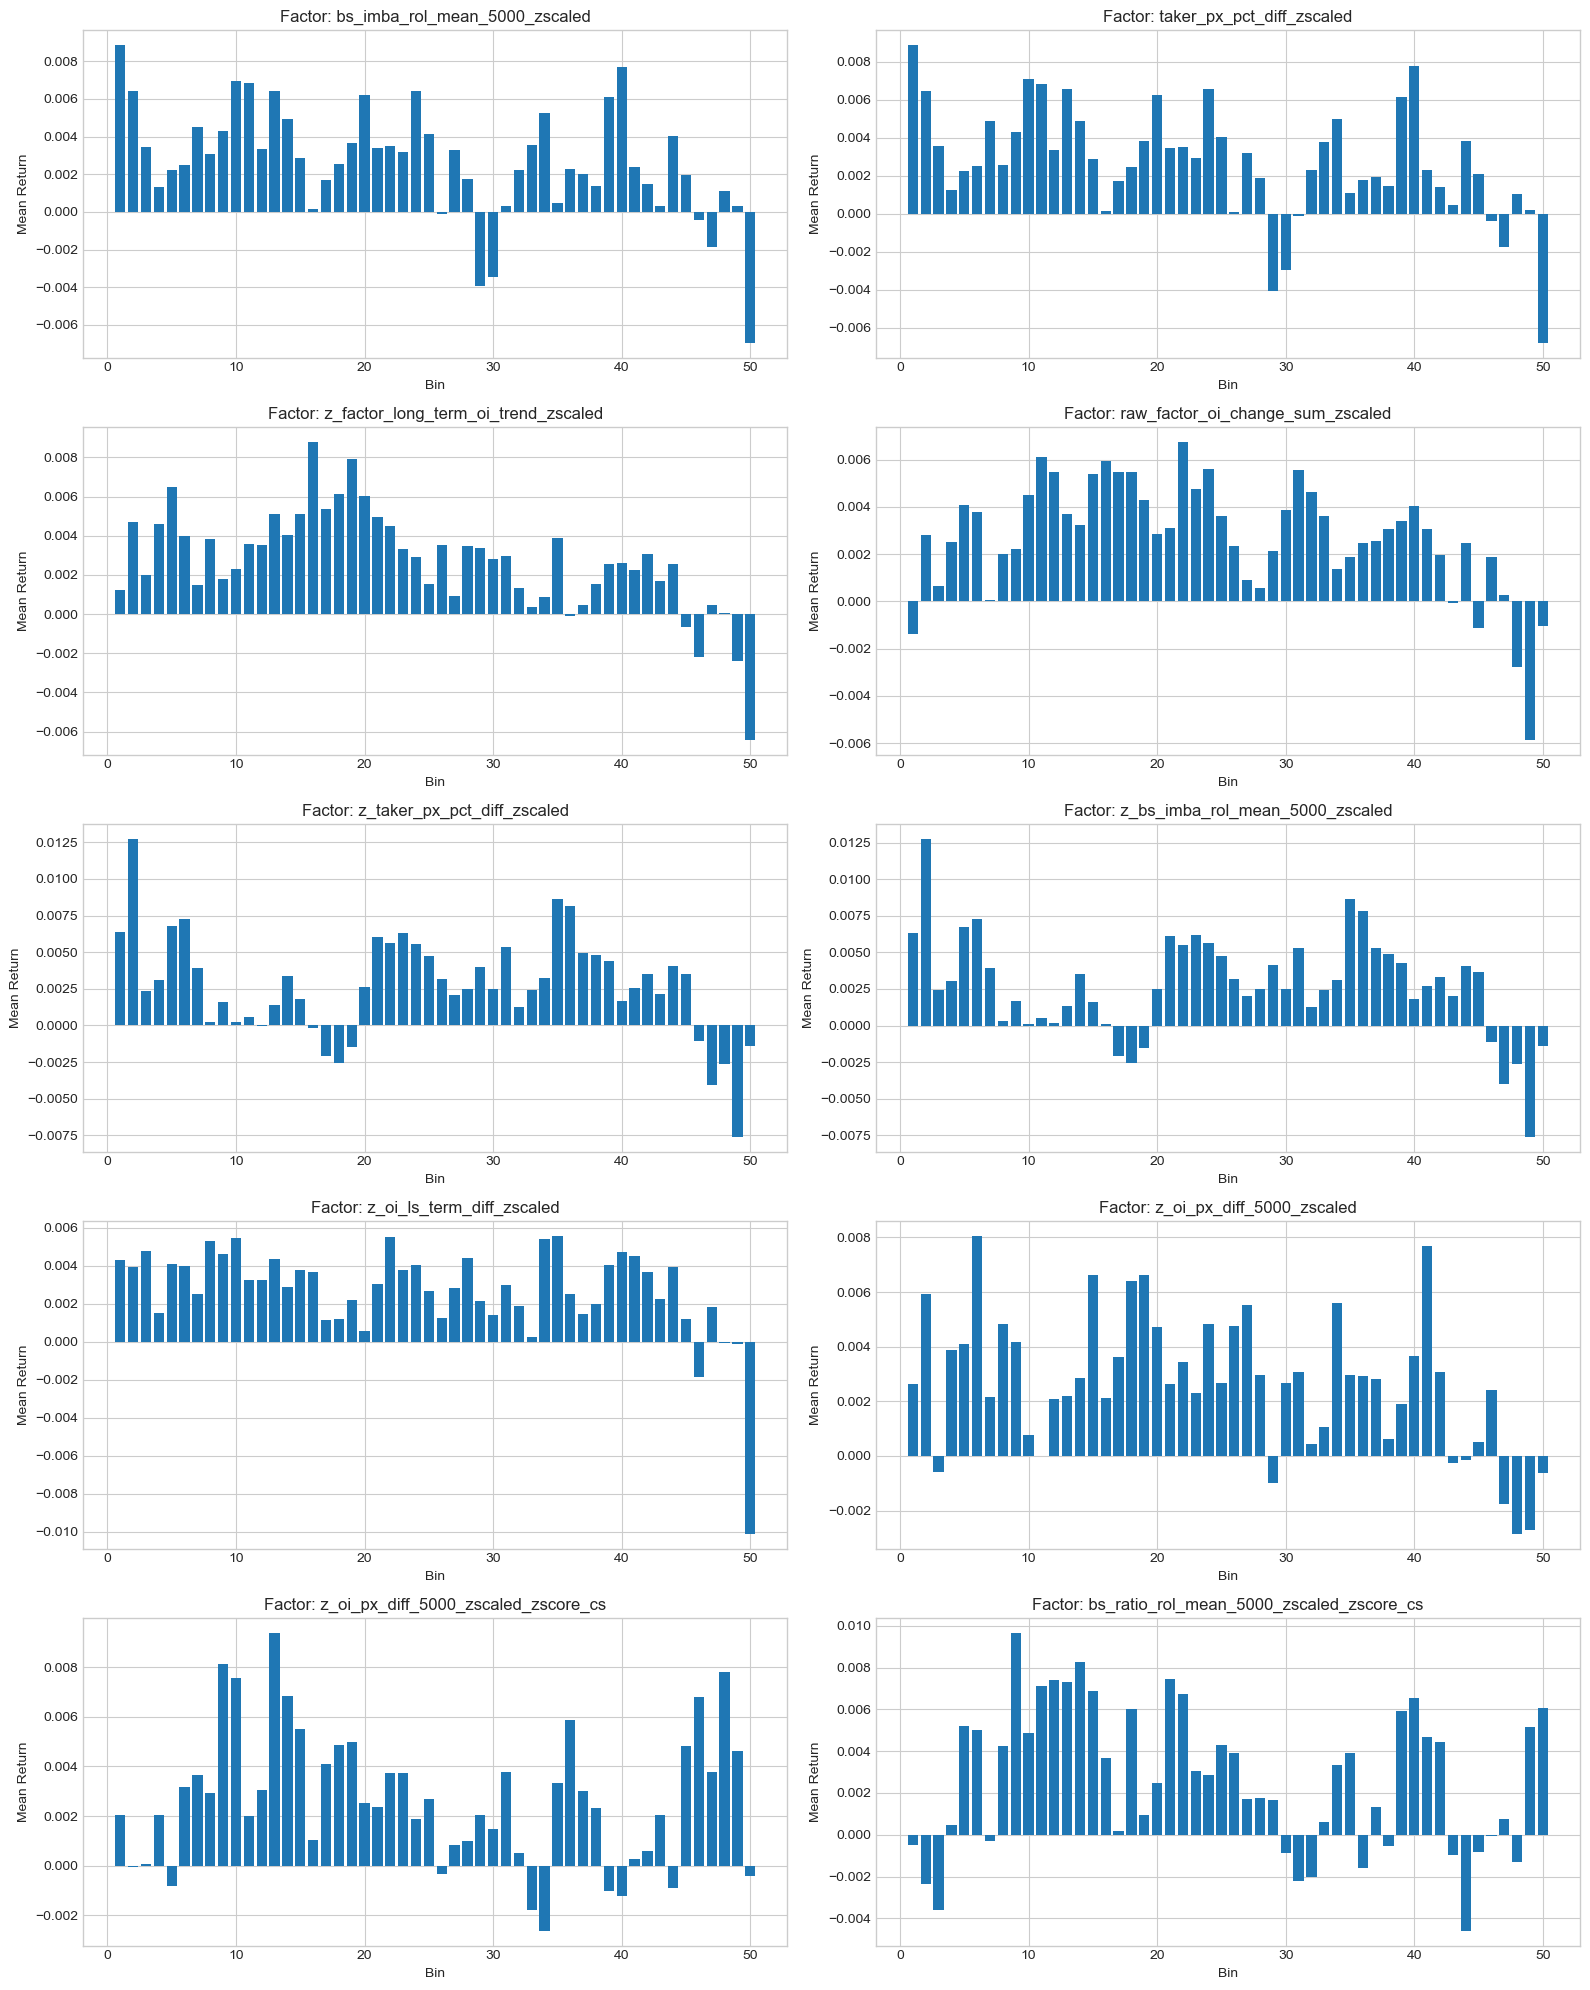

In [124]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, factor in enumerate(tail_factors):
    returns = bin_analysis(factor, weekly_dataframes, target_col, num_bins=50)
    axes[i].bar(range(1, 1 + len(returns)), returns)
    axes[i].set_title(f"Factor: {factor}")
    axes[i].set_xlabel("Bin")
    axes[i].set_ylabel("Mean Return")

plt.tight_layout()
plt.show()


In [125]:
print("总样本数：", len(full_df))


总样本数： 405336


In [126]:
print(sample_df["z_factor_oi_momentum_long_term_punch_zscaled_zscore_cs"])

shape: (1_640_016,)
Series: 'z_factor_oi_momentum_long_term_punch_zscaled_zscore_cs' [f64]
[
	-1.135073
	-0.602574
	1.960859
	0.90839
	-1.135073
	…
	1.021703
	-0.382159
	-0.607927
	1.386988
	0.763844
]


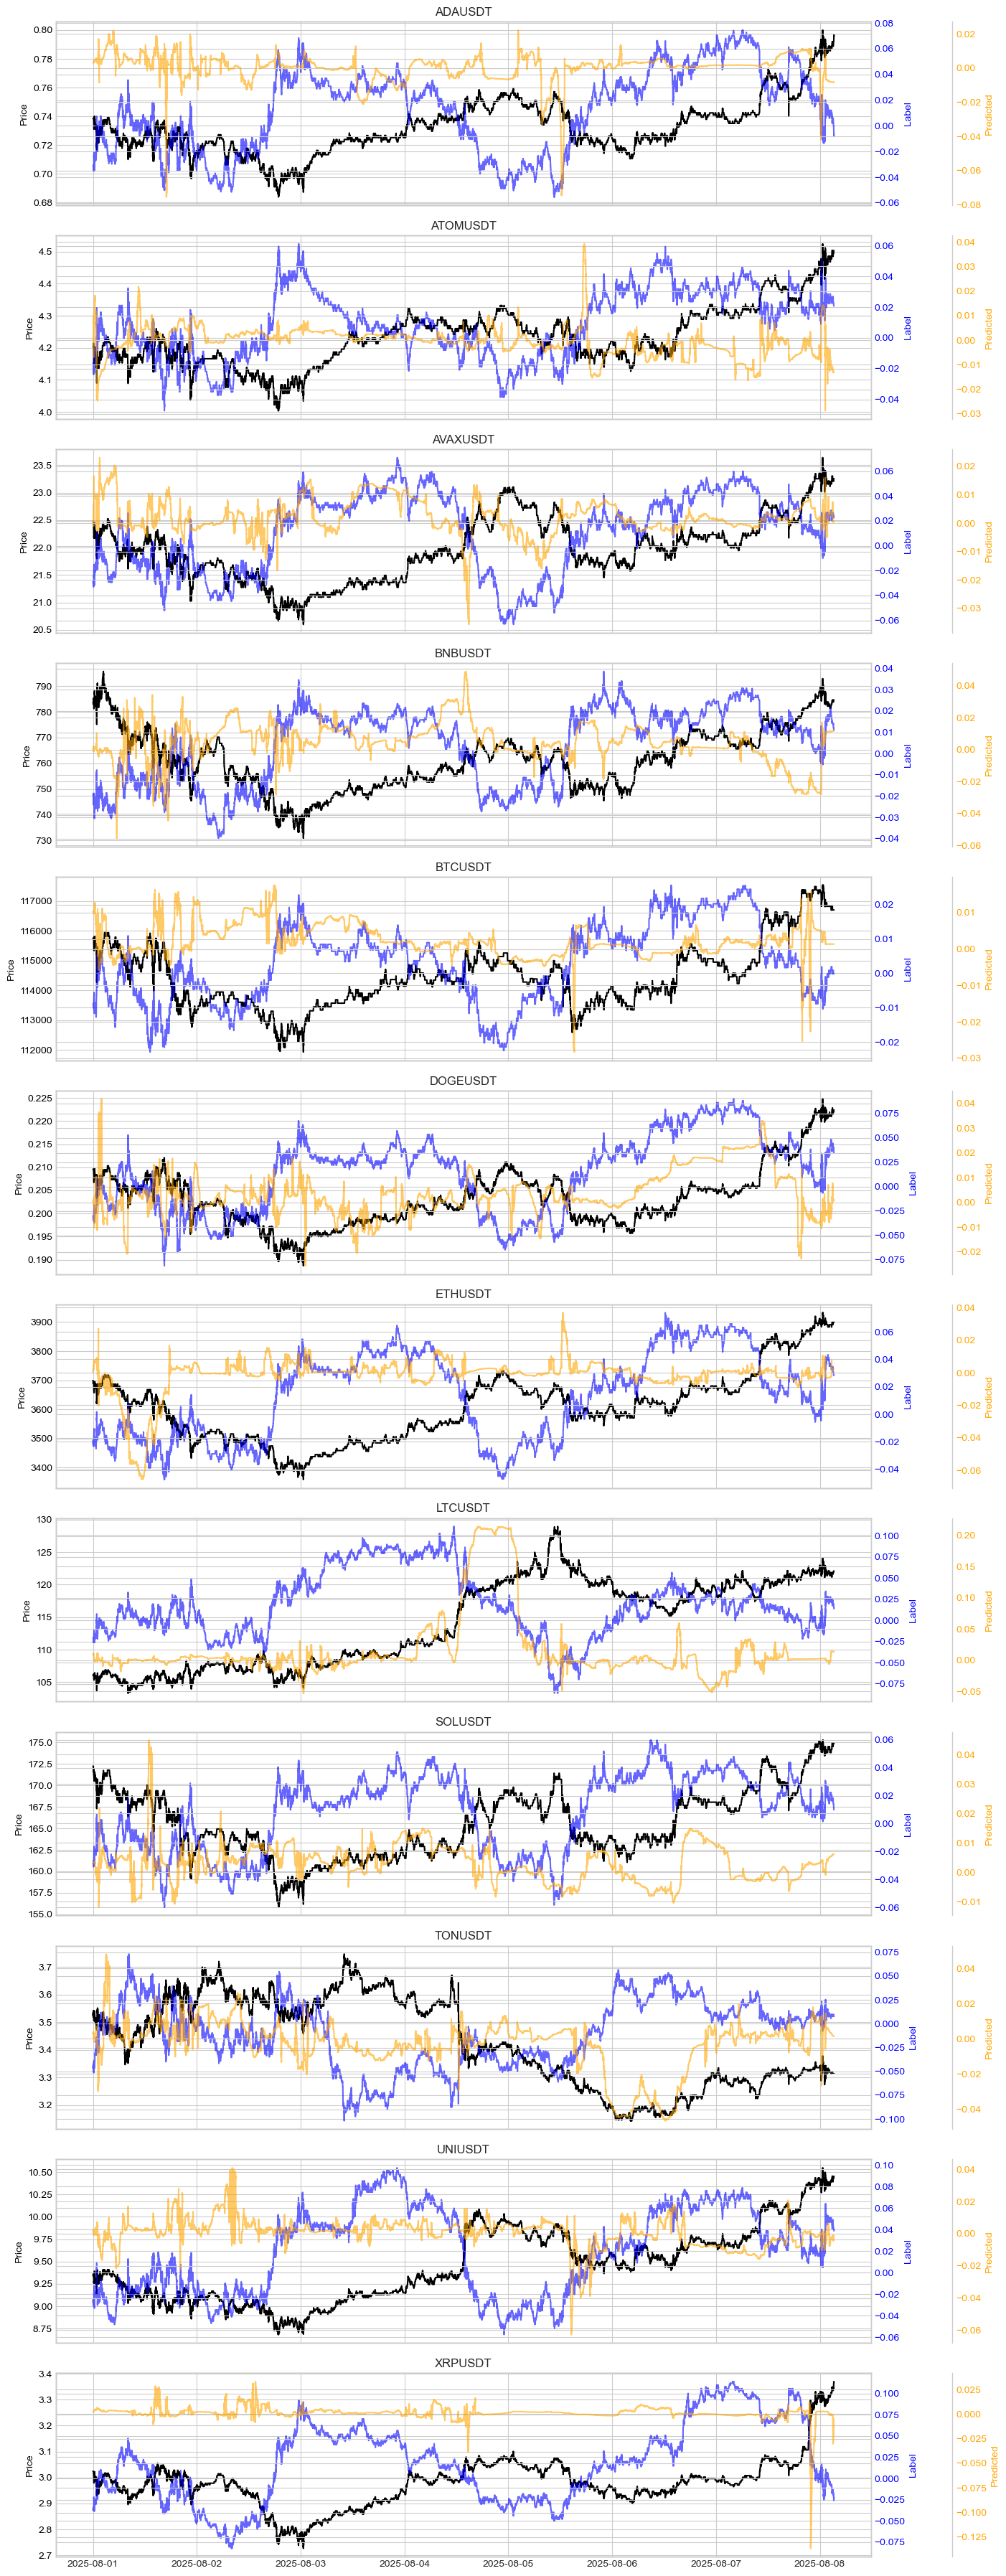

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已有 df，包含 symbol_enc、timestamp、true_label、predicted_prob、px、position（自行添加）
# 转换 timestamp 为时间格式（如需要）
df = full_df
df["timestamp"] = pd.to_datetime(full_df["timestamp"], unit="ms")

# 遍历每个币种
symbols = df["symbol_enc"].unique()
fig, axs = plt.subplots(len(symbols), 1, figsize=(14, 3 * len(symbols)), sharex=True)

if len(symbols) == 1:
    axs = [axs]

for i, sym in enumerate(symbols):
    sym_df = df[df["symbol_enc"] == sym].copy()
    
    ax = axs[i]
    sym_str = id_to_symbol[int(sym)]
    
    ax.set_title(f"{sym_str}")
    
    # 主轴: 价格
    ax.plot(sym_df["timestamp"], sym_df["px"], label="Price", color="black")
    ax.set_ylabel("Price", color="black")
    ax.tick_params(axis='y', labelcolor='black')

    # 第二轴: label
    ax2 = ax.twinx()
    ax2.plot(sym_df["timestamp"], sym_df["true_label"], label="Label", color="blue", alpha=0.6)
    ax2.set_ylabel("Label", color="blue")
    ax2.tick_params(axis='y', labelcolor='blue')

    # 第三轴: predicted prob
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.1))  # 偏移右边
    ax3.plot(sym_df["timestamp"], sym_df["predicted_prob"], label="Pred Prob", color="orange", alpha=0.6)
    ax3.set_ylabel("Predicted", color="orange")
    ax3.tick_params(axis='y', labelcolor='orange')

    # 第四轴: position（如果你有这个字段）
    if "position" in sym_df.columns:
        ax4 = ax.twinx()
        ax4.spines.right.set_position(("axes", 1.2))  # 更偏移右边
        ax4.plot(sym_df["timestamp"], sym_df["position"], label="Position", color="green", alpha=0.6)
        ax4.set_ylabel("Position", color="green")
        ax4.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()


Calculating IC: 100%|█████████████████████████████████████████████████████████████████████████████████████| 33778/33778 [00:10<00:00, 3073.80it/s]


平均IC: 0.0943
平均IC std: 0.3001
信息比率 IR: 0.3141


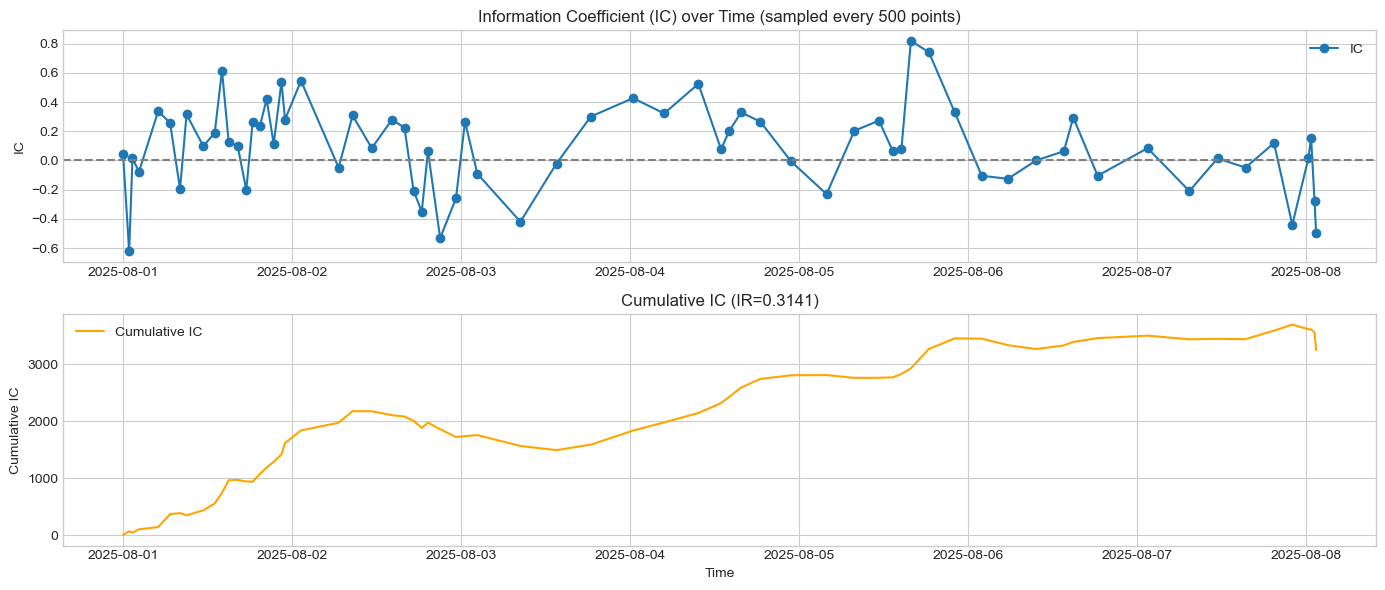

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

ic_list = []
time_list = []

# 计算每个时间截面的 IC
for ts, group in tqdm(full_df.groupby('timestamp'), total=full_df['timestamp'].nunique(), desc="Calculating IC"):
    if len(group) < 2:
        continue
    if group['predicted_prob'].nunique() < 2 or group['true_label'].nunique() < 2:
        continue
    ic, _ = spearmanr(group['predicted_prob'], group['true_label'])
    ic_list.append(ic)
    time_list.append(ts)

# 转为 np.array 和 datetime 格式（如需要）
ic_array = np.array(ic_list)
time_array = np.array(time_list)

# 排序时间（可选，保险做法）
sorted_idx = np.argsort(time_array)
time_array = time_array[sorted_idx]
ic_array = ic_array[sorted_idx]

# 计算累计 IC（cum IC）
cum_ic = np.cumsum(ic_array)

# 计算 IR（信息比率 = 平均IC / IC标准差）
ir = np.mean(ic_array) / np.std(ic_array)

# 打印信息
print(f"平均IC: {np.mean(ic_array):.4f}")
print(f"平均IC std: {np.std(ic_array):.4f}")

print(f"信息比率 IR: {ir:.4f}")

# 每隔500点采样一次
step = 500
time_array_sampled = time_array[::step]
ic_array_sampled = ic_array[::step]
cum_ic_sampled = cum_ic[::step]

# 绘图
plt.figure(figsize=(14, 6))

# 子图1: IC 时间序列图（采样后）
plt.subplot(2, 1, 1)
plt.plot(time_array_sampled, ic_array_sampled, marker='o', label='IC')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Information Coefficient (IC) over Time (sampled every 500 points)")
plt.ylabel("IC")
plt.legend()

# 子图2: 累积 IC 图（采样后）
plt.subplot(2, 1, 2)
plt.plot(time_array_sampled, cum_ic_sampled, color='orange', label='Cumulative IC')
plt.title(f"Cumulative IC (IR={ir:.4f})")
plt.xlabel("Time")
plt.ylabel("Cumulative IC")
plt.legend()

plt.tight_layout()
plt.show()


Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 385.12it/s]


--- Strategy Performance Statistics ---
Cumulative Return       -0.080799
Annualized Return       -0.115741
Annualized Volatility    0.063675
Sharpe Ratio            -1.817691
Max Drawdown            -0.091367
dtype: float64


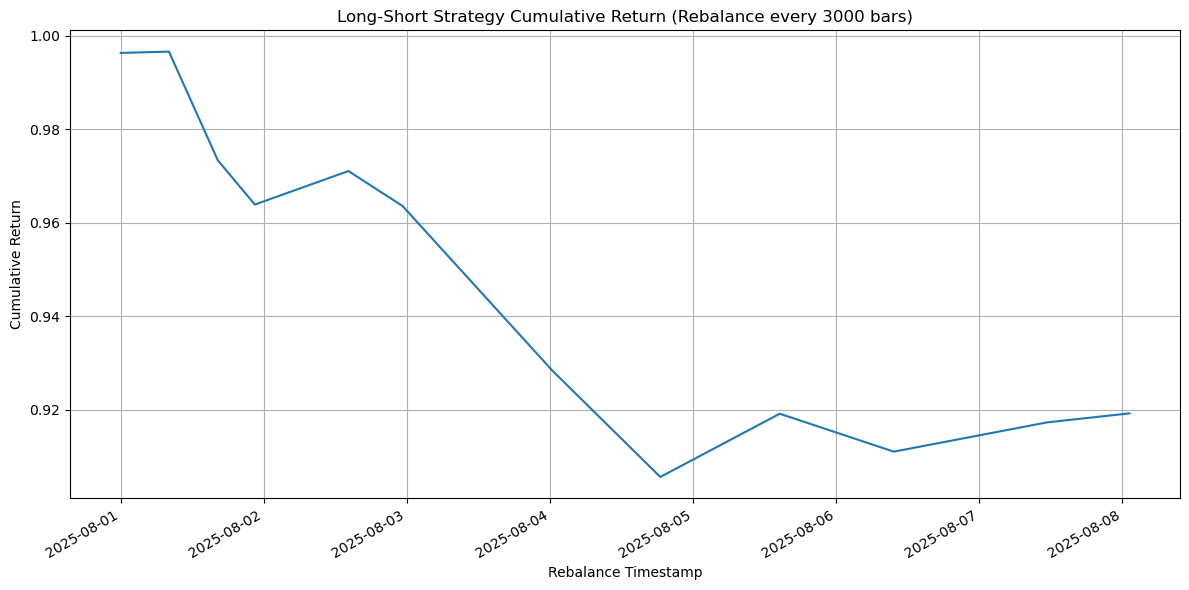

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp': 原始时间戳（例如毫秒），唯一且递增
# - 'symbol_enc': 币种编码
# - 'px': 当期价格
# - 'predicted_label': 模型预测的标签（分类或排名），越大表示越好

# --- 配置参数 ---
N_INTERVAL = N # 调仓周期，每 N_INTERVAL 个时间戳调仓一次

# N_INTERVAL = 1000 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次

# --- 数据预处理 ---
# 1. 转换时间戳为 datetime 类型，方便处理和绘图
bt_df = full_df
bt_df['dt'] = pd.to_datetime(full_df['timestamp'], unit='ms')

# 2. 确保数据按时间戳和币种排序，这是后续分组和shift操作的基础
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# 3. 获取所有唯一的、排序后的时间戳列表
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()

# 4. 确定所有调仓时间点
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
# 记录每个调仓时间点应持有的多空币种
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    # 筛选出当前调仓时间点 t 的所有币种数据（截面数据）
    current_snapshot = bt_df[bt_df['dt'] == t]
    if current_snapshot.empty:
        continue

    # 找出 predicted_label 最高（最好）和最低（最差）的币种
    # 使用 .idxmax() 和 .idxmin() 找到索引，再用 .loc[] 提取 symbol_enc
    long_symbol = current_snapshot.loc[current_snapshot['predicted_prob'].idxmax(), 'symbol_enc']
    short_symbol = current_snapshot.loc[current_snapshot['predicted_prob'].idxmin(), 'symbol_enc']

    rebalance_signals[t] = {'long': long_symbol, 'short': short_symbol}

# --- 构建调仓周期内的持仓和计算周期收益 ---
# 存储每个调仓周期的策略收益
period_returns = []

# 初始化当前持仓，确保从第一个调仓点开始生效
current_long_symbol = None
current_short_symbol = None

# 遍历每个调仓周期
for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    # 确定当前调仓周期结束时间
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 从 rebalance_signals 获取当前周期的多空币种
    if start_time in rebalance_signals:
        current_long_symbol = rebalance_signals[start_time]['long']
        current_short_symbol = rebalance_signals[start_time]['short']
    else:
        # 如果当前调仓点没有信号（不应发生），则沿用上一个周期的头寸或保持空仓
        # 这里为了简化，假设如果有信号就会找到，没有则保持上一个有效头寸
        # 如果需要严格空仓，可以在这里设置 current_long_symbol = None, current_short_symbol = None
        pass

    # 如果没有有效头寸，跳过此周期（收益为0）
    if current_long_symbol is None or current_short_symbol is None:
        period_returns.append({'dt': start_time, 'strategy_log_return': 0.0})
        continue

    # 筛选出当前调仓周期内的所有数据
    # 包括起始时间点（进行调仓），但不包括结束时间点（结算）
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

    # 获取多头和空头币种在该周期开始和结束时的价格
    long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]
    long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == current_long_symbol)]['px'].iloc[0]

    short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]
    short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['dt'] <= end_time) & (period_data['symbol_enc'] == current_short_symbol)]['px'].iloc[0]

    # 计算多头和空头在该周期内的对数收益率
    long_log_ret = np.log(long_end_px) - np.log(long_start_px)
    short_log_ret = np.log(short_end_px) - np.log(short_start_px)

    # 计算策略在该周期内的总对数收益（多头收益 + 空头收益的绝对值）
    # 假设各持仓权重相等，所以是 (多头收益 - 空头收益) / 2
    # 或者说，做多一个，做空一个，组合总收益
    strategy_period_log_return = (long_log_ret - short_log_ret) / 2 # 平均对冲策略

    period_returns.append({
        'dt': start_time,
        'strategy_log_return': strategy_period_log_return
    })

# 将周期收益转换为 DataFrame
strategy_returns_df = pd.DataFrame(period_returns).set_index('dt')
strategy_returns_series = strategy_returns_df['strategy_log_return']

# --- 绩效指标函数 ---
def perf_stats(return_series, periods_per_year):
    """
    计算并返回策略的绩效统计数据。
    return_series: 每个周期的对数收益率序列。
    periods_per_year: 一年内有多少个这样的周期（用于年化）。
    """
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp) # 对数收益累加后转回普通收益
    total_return = cum_ret.iloc[-1] - 1 # 累计普通收益

    # 年化收益率 (几何平均)
    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year) # 年化波动率
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    # 最大回撤 (基于普通收益)
    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# 假设每个时间戳是10分钟，N_INTERVAL=1000，则一个周期是 1000 * 10分钟 = 10000 分钟
# 一年大约有 52560 个10分钟的间隔 (365天 * 24小时 * 6个10分钟/小时)
# 则一年大约有 52560 / 1000 = 52.56 个 N_INTERVAL 周期
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 10分钟一档
# 或者更直接： (总时间戳数 / N_INTERVAL) / 总年数

stats = perf_stats(strategy_returns_series, periods_per_year_for_annualization)
print("\n--- Strategy Performance Statistics ---")
print(pd.Series(stats))

# --- 绘制累计收益曲线 ---
plt.figure(figsize=(12, 6))
# 对数收益累加，然后取指数，得到累计普通收益曲线
strategy_returns_series.cumsum().apply(np.exp).plot()
plt.title(f"Long-Short Strategy Cumulative Return (Rebalance every {N_INTERVAL} bars)")
plt.xlabel("Rebalance Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 253.06it/s]


--- Strategy Performance Statistics ---
Cumulative Return       -0.054179
Annualized Return       -0.078105
Annualized Volatility    0.039995
Sharpe Ratio            -1.952894
Max Drawdown            -0.060124
dtype: float64


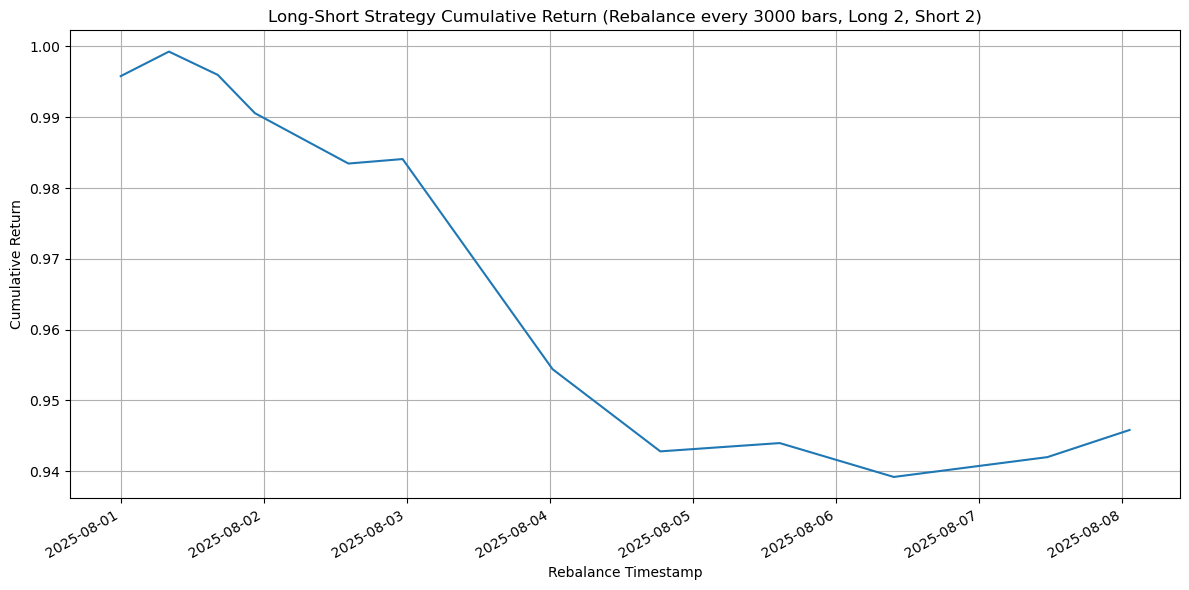

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_label'（模型预测的 rank_label，0=最差、3=最好，或你自己定义的分类）

# --- 配置参数 ---

N_INTERVAL = N # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
# N_INTERVAL = 1000 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
N_LONG = 2         # 做多的品种数量（例如，前2个最好的）
N_SHORT = 2       # 做空的品种数量（例如，后2个最差的）

# --- 数据预处理 ---
# 1. 转换时间戳为 datetime 类型，方便处理和绘图
bt_df = full_df
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')

# 2. 确保数据按时间戳和币种排序，这是后续分组和shift操作的基础
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)

# 3. 获取所有唯一的、排序后的时间戳列表
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()

# 4. 确定所有调仓时间点
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
# 记录每个调仓时间点应持有的多空币种列表
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy() # 使用.copy()避免SettingWithCopyWarning
    if current_snapshot.empty:
        continue

    # 根据 predicted_label 排序，选择前N_LONG和后N_SHORT个品种
    # 降序排列找到最好的，升序排列找到最差的
    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)

    # 选择前 N_LONG 个最好的品种做多
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    
    # 选择后 N_SHORT 个最差的品种做空
    # 注意：如果 N_LONG + N_SHORT > 总品种数，需要避免重复
    # 确保做空品种与做多品种不重叠
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols}

# --- 构建调仓周期内的持仓和计算周期收益 ---
# 存储每个调仓周期的策略收益
period_returns = []

# 初始化当前持仓，确保从第一个调仓点开始生效
current_long_symbols = []
current_short_symbols = []

# 遍历每个调仓周期
for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 获取当前周期的多空币种列表
    if start_time in rebalance_signals:
        current_long_symbols = rebalance_signals[start_time]['long']
        current_short_symbols = rebalance_signals[start_time]['short']
    else:
        # 如果当前调仓点没有信号（不应发生），则沿用上一个周期的头寸或保持空仓
        pass # 维持前一周期头寸

    # 如果没有有效头寸（或数量不够），跳过此周期（收益为0）
    if not current_long_symbols or not current_short_symbols:
        period_returns.append({'dt': start_time, 'strategy_log_return': 0.0})
        continue

    # 筛选出当前调仓周期内的所有数据
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

    total_period_log_return = 0.0

    # 计算多头组合收益
    long_portfolio_log_return = 0.0
    for symbol in current_long_symbols:
        try:
            long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
        except IndexError:
            # 币种数据缺失处理
            # print(f"Warning: Data for {symbol} missing at {start_time} or {end_time}")
            pass # 或者采取其他更严格的缺失处理方式

    # 计算空头组合收益
    short_portfolio_log_return = 0.0
    for symbol in current_short_symbols:
        try:
            short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
            short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
        except IndexError:
            # 币种数据缺失处理
            # print(f"Warning: Data for {symbol} missing at {start_time} or {end_time}")
            pass # 或者采取其他更严格的缺失处理方式

    # 平均权重计算组合收益：(多头组合收益 - 空头组合收益) / 总持仓品种数
    # 假设每个选中的品种权重相等
    num_traded_symbols = len(current_long_symbols) + len(current_short_symbols)
    if num_traded_symbols > 0:
        total_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_traded_symbols
    else:
        total_period_log_return = 0.0 # 没有有效交易则收益为0

    period_returns.append({
        'dt': start_time,
        'strategy_log_return': total_period_log_return
    })

# 将周期收益转换为 DataFrame
strategy_returns_df = pd.DataFrame(period_returns).set_index('dt')
strategy_returns_series = strategy_returns_df['strategy_log_return']

# --- 绩效指标函数 (与之前相同，但强调基于周期性收益) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# 假设每个时间戳是10分钟，N_INTERVAL=1000，则一个周期是 1000 * 10分钟 = 10000 分钟
# 则一年大约有 52560 / 1000 = 52.56 个 N_INTERVAL 周期
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 10分钟一档
# 请根据你的数据实际频率和 N_INTERVAL 重新计算此值！

stats = perf_stats(strategy_returns_series, periods_per_year_for_annualization)
print("\n--- Strategy Performance Statistics ---")
print(pd.Series(stats))

# --- 绘制累计收益曲线 ---
plt.figure(figsize=(12, 6))
strategy_returns_series.cumsum().apply(np.exp).plot()
plt.title(f"Long-Short Strategy Cumulative Return (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
plt.xlabel("Rebalance Timestamp")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 189.59it/s]



--- Strategy Performance Statistics (Gross) ---
Cumulative Return       -0.054179
Annualized Return       -0.078105
Annualized Volatility    0.039995
Sharpe Ratio            -1.952894
Max Drawdown            -0.060124
dtype: float64

--- Strategy Performance Statistics (Net of Costs) ---
Cumulative Return       -0.071051
Annualized Return       -0.102017
Annualized Volatility    0.039951
Sharpe Ratio            -2.553558
Max Drawdown            -0.070870
dtype: float64

Total Transaction Cost (Sum of individual costs): 0.018000


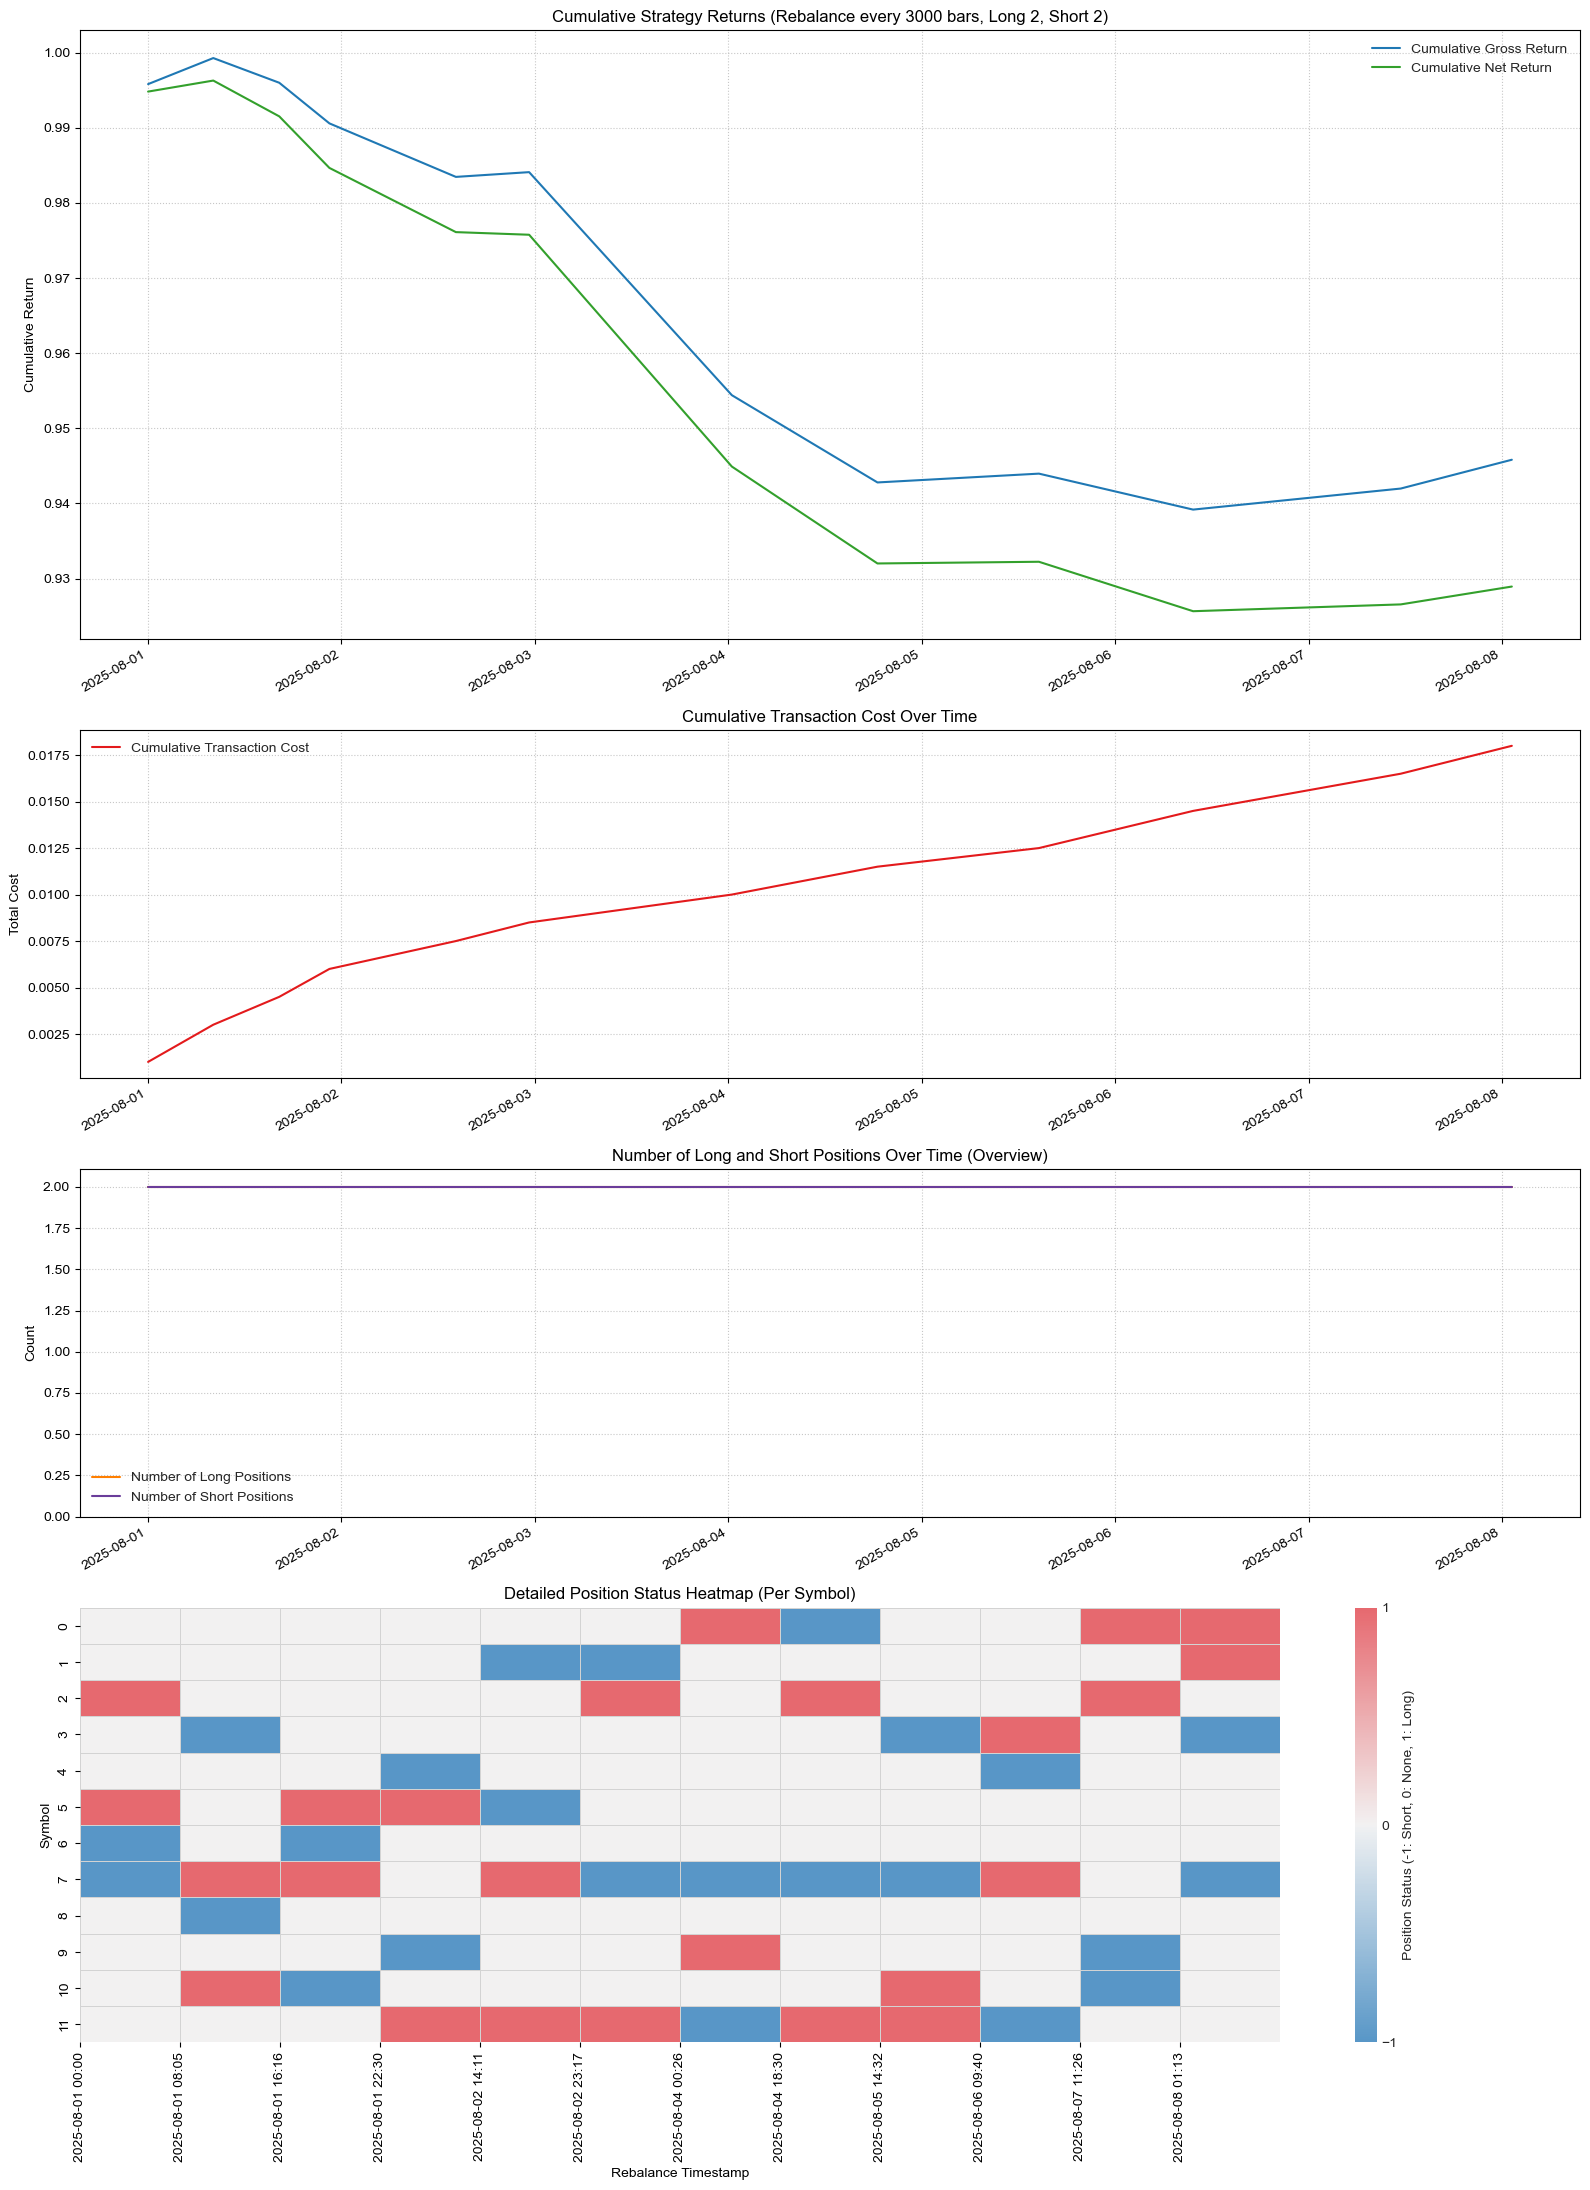

{np.int64(0): np.str_('ADAUSDT'), np.int64(1): np.str_('ATOMUSDT'), np.int64(2): np.str_('AVAXUSDT'), np.int64(3): np.str_('BNBUSDT'), np.int64(4): np.str_('BTCUSDT'), np.int64(5): np.str_('DOGEUSDT'), np.int64(6): np.str_('ETHUSDT'), np.int64(7): np.str_('LTCUSDT'), np.int64(8): np.str_('SOLUSDT'), np.int64(9): np.str_('TONUSDT'), np.int64(10): np.str_('UNIUSDT'), np.int64(11): np.str_('XRPUSDT')}


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
bt_df = full_df

N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
N_LONG = 2    # 做多的品种数量
N_SHORT = 2      # 做空的品种数量
TRANSACTION_COST_PER_TRADE = 0.001 / (N_LONG + N_SHORT)


# --- 数据预处理 (与之前相同) ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）(与之前相同) ---
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        continue

    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols}

# --- 构建调仓周期内的持仓和计算周期收益 (与之前相同) ---
period_results = []
all_positions_by_period = []

current_long_symbols = []
current_short_symbols = []

for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    prev_long_symbols = current_long_symbols[:]
    prev_short_symbols = current_short_symbols[:]

    if start_time in rebalance_signals:
        current_long_symbols = rebalance_signals[start_time]['long']
        current_short_symbols = rebalance_signals[start_time]['short']
    
    # --- 记录当前调仓周期所有品种的持仓状态 ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_period_positions = {symbol: 0 for symbol in all_unique_symbols}

    for symbol in current_long_symbols:
        current_period_positions[symbol] = 1

    for symbol in current_short_symbols:
        if current_period_positions[symbol] != 1:
            current_period_positions[symbol] = -1

    all_positions_by_period.append({'dt': start_time, **current_period_positions})

    # --- 计算本周期的策略收益 (毛收益) ---
    gross_period_log_return = 0.0
    if not current_long_symbols or not current_short_symbols:
        gross_period_log_return = 0.0
    else:
        period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()

        long_portfolio_log_return = 0.0
        for symbol in current_long_symbols:
            try:
                long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
            except IndexError:
                long_portfolio_log_return += 0.0
                pass

        short_portfolio_log_return = 0.0
        for symbol in current_short_symbols:
            try:
                short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
            except IndexError:
                short_portfolio_log_return += 0.0
                pass

        num_traded_symbols = len(current_long_symbols) + len(current_short_symbols)
        if num_traded_symbols > 0:
            gross_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_traded_symbols
        else:
            gross_period_log_return = 0.0

    # --- 计算本周期的交易手续费 ---
    transaction_cost_this_period = 0.0
    if i > 0:
        close_long_count = len([s for s in prev_long_symbols if s not in current_long_symbols])
        close_short_count = len([s for s in prev_short_symbols if s not in current_short_symbols])
        
        open_long_count = len([s for s in current_long_symbols if s not in prev_long_symbols])
        open_short_count = len([s for s in current_short_symbols if s not in prev_short_symbols])
        
        transaction_cost_this_period = (close_long_count + close_short_count + open_long_count + open_short_count) * TRANSACTION_COST_PER_TRADE
    else:
        transaction_cost_this_period = (len(current_long_symbols) + len(current_short_symbols)) * TRANSACTION_COST_PER_TRADE

    net_period_log_return = gross_period_log_return - transaction_cost_this_period 
    
    period_results.append({
        'dt': start_time,
        'gross_strategy_log_return': gross_period_log_return,
        'transaction_cost': transaction_cost_this_period,
        'net_strategy_log_return': net_period_log_return,
        'num_long_positions': len(current_long_symbols),
        'num_short_positions': len(current_short_symbols),
        'long_symbols_list': current_long_symbols,
        'short_symbols_list': current_short_symbols
    })

# 将周期结果转换为 DataFrame
strategy_results_df = pd.DataFrame(period_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_period).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 (与之前相同) ---
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) 

print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
# 可以选择 seaborn 的 palette，或者自定义 HEX 颜色
# muted, pastel, dark, bright, deep, colorblind
# 例如：sns.color_palette("muted") 或 sns.color_palette("viridis", as_cmap=True)

# 曲线图颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1] # 柔和的蓝色
COLOR_NET_RETURN = sns.color_palette("Paired")[3]   # 柔和的绿色
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5] # 柔和的红色
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7] # 柔和的紫色
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9] # 柔和的橙色

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1) # 240 (蓝) 到 10 (红), 饱和度70, 亮度60, 分离度1
# 其他可选的低饱和度发散型色图： 'coolwarm_r', 'Spectral_r', 'vlag', 'icefire'
# 或者自定义一个更温和的 RdBu
# HEATMAP_CMAP = plt.cm.get_cmap('RdBu', 3) # RdBu色图取3个离散值，可能需要进一步调低饱和度
# HEATMAP_CMAP = LinearSegmentedColormap.from_list("mycmap", [(0, "darkred"), (0.5, "lightgray"), (1, "darkblue")]) # 更精细自定义

# 设置图表背景风格 (可选，例如设置为白色背景)
plt.style.use('seaborn-v0_8-whitegrid') # 或者 'seaborn-v0_8-pastel' / 'seaborn-v0_8-muted'


# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['gross_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN)
strategy_results_df['net_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7) # 调整网格线样式和透明度
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化 (保留，作为快速概览)
strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图
if not positions_heatmap_df.empty:
    sns.heatmap(
        positions_heatmap_df.T,
        cmap=HEATMAP_CMAP, # 使用新的低饱和度色图
        cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=True,
        linewidths=0.5, # 增加网格线
        linecolor='lightgray' # 网格线颜色
    )
    axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
    axes[3].set_xlabel("Rebalance Timestamp")
    axes[3].set_ylabel("Symbol")
    
    # 调整x轴刻度标签，避免重叠
    num_ticks = 10 
    if len(positions_heatmap_df.index) > num_ticks:
        tick_interval = len(positions_heatmap_df.index) // num_ticks
        axes[3].set_xticks(np.arange(0, len(positions_heatmap_df.index), tick_interval))
        axes[3].set_xticklabels(positions_heatmap_df.index[::tick_interval].strftime('%Y-%m-%d %H:%M'))
    else:
        axes[3].set_xticklabels(positions_heatmap_df.index.strftime('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()
print(id_to_symbol)

In [44]:
print(id_to_symbol)
print(type(id_to_symbol))

{np.int64(0): np.str_('ADAUSDT'), np.int64(1): np.str_('ATOMUSDT'), np.int64(2): np.str_('AVAXUSDT'), np.int64(3): np.str_('BNBUSDT'), np.int64(4): np.str_('BTCUSDT'), np.int64(5): np.str_('DOGEUSDT'), np.int64(6): np.str_('ETHUSDT'), np.int64(7): np.str_('LTCUSDT'), np.int64(8): np.str_('SOLUSDT'), np.int64(9): np.str_('TONUSDT'), np.int64(10): np.str_('UNIUSDT'), np.int64(11): np.str_('XRPUSDT')}
<class 'dict'>


Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 100.30it/s]



--- Strategy Performance Statistics (Gross) ---
Cumulative Return       -0.041458
Annualized Return       -0.059947
Annualized Volatility    0.028622
Sharpe Ratio            -2.094422
Max Drawdown            -0.049055
dtype: float64

--- Strategy Performance Statistics (Net of Costs) ---
Cumulative Return       -0.051636
Annualized Return       -0.074485
Annualized Volatility    0.028703
Sharpe Ratio            -2.595019
Max Drawdown            -0.057175
dtype: float64

Total Transaction Cost (Sum of individual costs): 0.010675


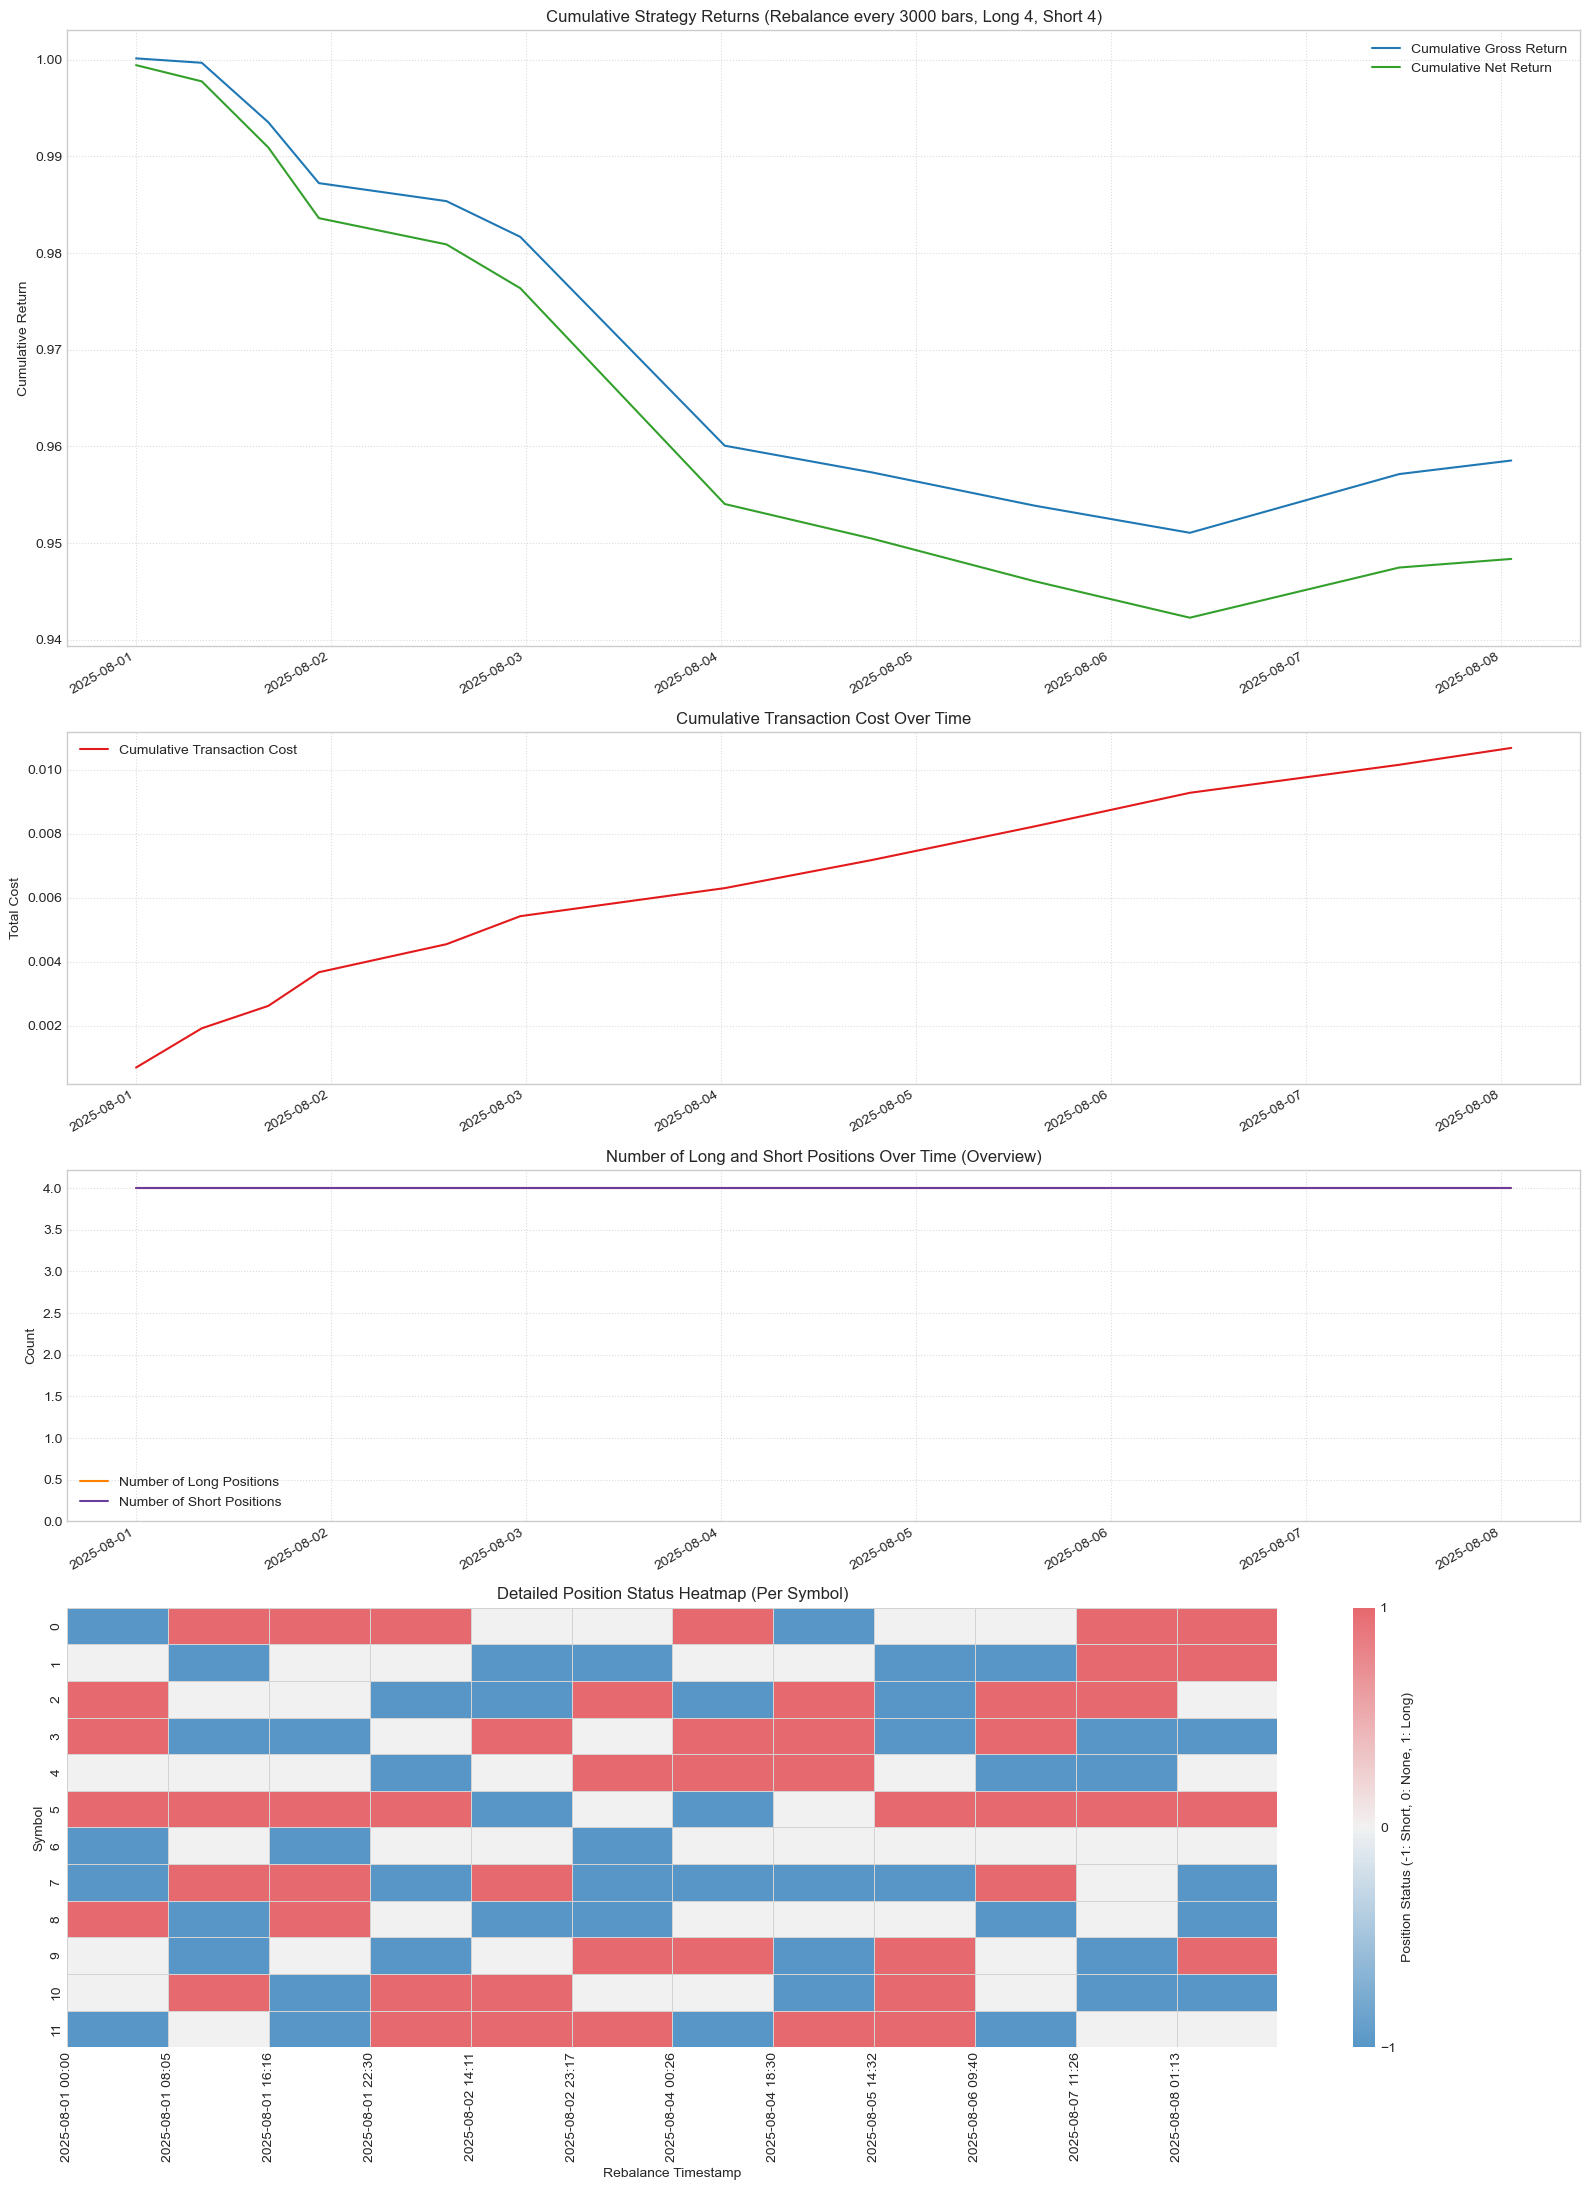

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
# 注意：你的原始代码中 bt_df = full_df，这里假设 full_df 已经被传入或定义
# 如果 full_df 是一个未定义的变量，你需要在这里定义或加载它
# 例如：bt_df = pd.read_csv('your_data.csv')
# 或者 bt_df = full_df # 如果 full_df 在此脚本外部定义

# 这里N是一个未定义的变量，你需要给它一个具体的值，例如 100
bt_df = full_df 


N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
# N_INTERVAL = 200
N_LONG = 4     # 做多的品种数量
N_SHORT = 4      # 做空的品种数量
TRANSACTION_COST_PER_TRADE = 0.0007 / (N_LONG + N_SHORT)

# 新增：单币种止损参数
STOP_LOSS_PERCENT = 0.15 # 单币种止损百分比，例如 0.05 表示 5% 的亏损止损

# --- 数据预处理 ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
rebalance_signals = {}
for t in tqdm(rebalance_times, desc="Identifying Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}} # 增加prices字典
        continue

    # 根据预测值排序
    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    
    # 选择多头和空头品种
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    
    # 确保做空品种不与做多品种重复
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    # !!! 强制多空同时开仓 !!!
    if not long_symbols or not short_symbols:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
    else:
        # 记录开仓时的价格
        prices = {}
        for symbol in long_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px
        for symbol in short_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px

        rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols, 'prices': prices}

# --- 构建调仓周期内的持仓和计算周期收益 ---
period_results = []
all_positions_by_period = []

current_long_positions = {}  # {symbol: open_price}
current_short_positions = {} # {symbol: open_price}

for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 获取当前周期的数据快照
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()
    if period_data.empty:
        # 如果当前时间段没有数据，则跳过
        continue

    # 获取当前时间点（周期开始）的价格快照，用于调仓决策
    current_moment_prices = bt_df[bt_df['dt'] == start_time].set_index('symbol_enc')['px'].to_dict()
    current_moment_preds = bt_df[bt_df['dt'] == start_time].set_index('symbol_enc')['predicted_prob'].to_dict()

    # 复制上一个周期的持仓，用于计算交易费用
    prev_long_symbols_for_cost = list(current_long_positions.keys())
    prev_short_symbols_for_cost = list(current_short_positions.keys())

    # --- Step 1: 检查并处理单币种止损 ---
    # 在调仓之前，先处理已有的持仓是否触及止损
    symbols_to_close = {'long': [], 'short': []}
    current_period_transaction_cost = 0.0 # 用于累加本周期内的所有交易成本

    # 遍历现有长仓检查止损
    for symbol, open_px in list(current_long_positions.items()): # 使用list()避免在迭代时修改字典
        current_px = current_moment_prices.get(symbol)
        if current_px is not None and open_px is not None and (open_px - current_px) / open_px >= STOP_LOSS_PERCENT:
            # 触发止损
            del current_long_positions[symbol]
            symbols_to_close['long'].append(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # 开仓一次，平仓一次，所以是2

            # print(f"Stop-loss triggered for LONG {symbol} at {start_time.strftime('%Y-%m-%d %H:%M')}. Loss: {(open_px - current_px) / open_px:.2%}")

            # 联动平仓最弱的空头仓位
            if current_short_positions:
                # 找到当前所有空头品种的预测值，选择预测值最高的（最不看跌的，即最弱的空头）
                weakest_short_symbol = None
                highest_pred_for_short = -float('inf')
                
                # 遍历当前空头持仓，结合最新预测值来判断哪个是“最弱”的空头
                # “最弱”的空头意味着其看跌倾向最不明显，或者甚至开始看涨了
                for s in current_short_positions.keys():
                    pred_val = current_moment_preds.get(s)
                    if pred_val is not None and pred_val > highest_pred_for_short:
                        highest_pred_for_short = pred_val
                        weakest_short_symbol = s
                
                if weakest_short_symbol:
                    del current_short_positions[weakest_short_symbol]
                    symbols_to_close['short'].append(weakest_short_symbol)
                    current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # 联动平仓也算费用
                    print(f"  -> Linkage: Closed weakest SHORT {weakest_short_symbol} to rebalance.")
            
    # 遍历现有短仓检查止损
    for symbol, open_px in list(current_short_positions.items()):
        current_px = current_moment_prices.get(symbol)
        if current_px is not None and open_px is not None and (current_px - open_px) / open_px >= STOP_LOSS_PERCENT:
            # 触发止损
            del current_short_positions[symbol]
            symbols_to_close['short'].append(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2

            # print(f"Stop-loss triggered for SHORT {symbol} at {start_time.strftime('%Y-%m-%d %H:%M')}. Loss: {(current_px - open_px) / open_px:.2%}")

            # 联动平仓最弱的多头仓位
            if current_long_positions:
                # 找到当前所有多头品种的预测值，选择预测值最低的（最不看涨的，即最弱的多头）
                weakest_long_symbol = None
                lowest_pred_for_long = float('inf')

                # 遍历当前多头持仓，结合最新预测值来判断哪个是“最弱”的多头
                # “最弱”的多头意味着其看涨倾向最不明显，或者甚至开始看跌了
                for s in current_long_positions.keys():
                    pred_val = current_moment_preds.get(s)
                    if pred_val is not None and pred_val < lowest_pred_for_long:
                        lowest_pred_for_long = pred_val
                        weakest_long_symbol = s

                if weakest_long_symbol:
                    del current_long_positions[weakest_long_symbol]
                    symbols_to_close['long'].append(weakest_long_symbol)
                    current_period_transaction_cost += TRANSACTION_COST_PER_TRADE * 2
                    print(f"  -> Linkage: Closed weakest LONG {weakest_long_symbol} to rebalance.")


    # --- Step 2: 根据调仓信号更新持仓 ---
    # 获取本周期的目标持仓
    target_long_symbols = rebalance_signals[start_time]['long']
    target_short_symbols = rebalance_signals[start_time]['short']
    target_prices = rebalance_signals[start_time]['prices'] # 目标开仓价格

    # 平仓不再持有的仓位
    for symbol in list(current_long_positions.keys()):
        if symbol not in target_long_symbols:
            del current_long_positions[symbol]
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 平仓费用
            symbols_to_close['long'].append(symbol) # 记录平仓

    for symbol in list(current_short_positions.keys()):
        if symbol not in target_short_symbols:
            del current_short_positions[symbol]
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 平仓费用
            symbols_to_close['short'].append(symbol) # 记录平仓

    # 开仓新的仓位
    for symbol in target_long_symbols:
        if symbol not in current_long_positions:
            current_long_positions[symbol] = target_prices.get(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 开仓费用

    for symbol in target_short_symbols:
        if symbol not in current_short_positions:
            current_short_positions[symbol] = target_prices.get(symbol)
            current_period_transaction_cost += TRANSACTION_COST_PER_TRADE # 开仓费用

    # --- Step 3: 计算本周期的策略收益 (毛收益) ---
    gross_period_log_return = 0.0
    if not current_long_positions and not current_short_positions: # 如果本周期开始和结束都没有持仓
        gross_period_log_return = 0.0
    else:
        long_portfolio_log_return = 0.0
        for symbol, open_px in current_long_positions.items():
            try:
                # 获取本周期末的价格
                long_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                # 这里应该用当前周期开始的价格（start_time的价格）来计算周期收益，而不是开仓价格
                long_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                long_portfolio_log_return += (np.log(long_end_px) - np.log(long_start_px))
            except IndexError:
                # 如果这个品种在当前周期数据中缺失，则不计算其收益
                long_portfolio_log_return += 0.0
                pass

        short_portfolio_log_return = 0.0
        for symbol, open_px in current_short_positions.items():
            try:
                short_end_px = period_data[(period_data['dt'] == end_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_start_px = period_data[(period_data['dt'] == start_time) & (period_data['symbol_enc'] == symbol)]['px'].iloc[0]
                short_portfolio_log_return += (np.log(short_end_px) - np.log(short_start_px))
            except IndexError:
                short_portfolio_log_return += 0.0
                pass

        num_active_positions = len(current_long_positions) + len(current_short_positions)
        if num_active_positions > 0:
            gross_period_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_active_positions
        else:
            gross_period_log_return = 0.0

    net_period_log_return = gross_period_log_return - current_period_transaction_cost

    # --- 记录当前调仓周期所有品种的持仓状态 (用于热力图) ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_period_positions_for_heatmap = {symbol: 0 for symbol in all_unique_symbols}

    for symbol in current_long_positions.keys():
        current_period_positions_for_heatmap[symbol] = 1

    for symbol in current_short_positions.keys():
        if current_period_positions_for_heatmap[symbol] != 1: # 避免与多头冲突
            current_period_positions_for_heatmap[symbol] = -1

    all_positions_by_period.append({'dt': start_time, **current_period_positions_for_heatmap})


    period_results.append({
        'dt': start_time,
        'gross_strategy_log_return': gross_period_log_return,
        'transaction_cost': current_period_transaction_cost, # 本周期总费用
        'net_strategy_log_return': net_period_log_return,
        'num_long_positions': len(current_long_positions),
        'num_short_positions': len(current_short_positions),
        'long_symbols_list': list(current_long_positions.keys()),
        'short_symbols_list': list(current_short_positions.keys())
    })

# 将周期结果转换为 DataFrame
strategy_results_df = pd.DataFrame(period_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_period).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 假设10ms一个bar

print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1]
COLOR_NET_RETURN = sns.color_palette("Paired")[3]
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5]
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7]
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9]

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1)

# 设置图表背景风格 (可选，例如设置为白色背景)
plt.style.use('seaborn-v0_8-whitegrid')

# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['gross_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN)
strategy_results_df['net_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化 (保留，作为快速概览)
strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图
if not positions_heatmap_df.empty:
    sns.heatmap(
        positions_heatmap_df.T,
        cmap=HEATMAP_CMAP,
        cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=True,
        linewidths=0.5,
        linecolor='lightgray'
    )
    axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
    axes[3].set_xlabel("Rebalance Timestamp")
    axes[3].set_ylabel("Symbol")
    
    # 调整x轴刻度标签，避免重叠
    num_ticks = 10 
    if len(positions_heatmap_df.index) > num_ticks:
        tick_interval = len(positions_heatmap_df.index) // num_ticks
        axes[3].set_xticks(np.arange(0, len(positions_heatmap_df.index), tick_interval))
        axes[3].set_xticklabels(positions_heatmap_df.index[::tick_interval].strftime('%Y-%m-%d %H:%M'))
    else:
        axes[3].set_xticklabels(positions_heatmap_df.index.strftime('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
# 注意：你的原始代码中 bt_df = full_df，这里假设 full_df 已经被传入或定义
# 如果 full_df 是一个未定义的变量，你需要在这里定义或加载它
# 例如：bt_df = pd.read_csv('your_data.csv')
# 或者 bt_df = full_df # 如果 full_df 在此脚本外部定义

# 这里N是一个未定义的变量，你需要给它一个具体的值，例如 100
bt_df = full_df 

# N = 2000
N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
N_LONG = 5      # 做多的品种数量
N_SHORT = 5       # 做空的品种数量
TRANSACTION_COST_PER_TRADE = 0.001 / (N_LONG + N_SHORT)

# 新增：单币种止损参数
STOP_LOSS_PERCENT = 0.15 # 单币种止损百分比，例如 0.05 表示 5% 的亏损止损

# --- 数据预处理 ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()

# --- 识别调仓信号 (在每个可能的调仓时间点，提前计算以提高效率) ---
# This part remains similar, as rebalance signals are still based on fixed intervals.
rebalance_times = timestamps_sorted[::N_INTERVAL]
rebalance_signals = {}

for t in tqdm(rebalance_times, desc="Pre-calculating Rebalance Signals"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
        continue

    sorted_by_prediction = current_snapshot.sort_values(by='predicted_prob', ascending=False)
    
    long_symbols = sorted_by_prediction.head(N_LONG)['symbol_enc'].tolist()
    short_symbols_potential = sorted_by_prediction.tail(N_SHORT)['symbol_enc'].tolist()
    
    short_symbols = [s for s in short_symbols_potential if s not in long_symbols]

    if not long_symbols or not short_symbols:
        rebalance_signals[t] = {'long': [], 'short': [], 'prices': {}}
    else:
        prices = {}
        for symbol in long_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px
        for symbol in short_symbols:
            px = current_snapshot[current_snapshot['symbol_enc'] == symbol]['px'].iloc[0]
            prices[symbol] = px
        rebalance_signals[t] = {'long': long_symbols, 'short': short_symbols, 'prices': prices}

# --- Bar-by-Bar 回测模拟 ---
daily_results = []
all_positions_by_bar = []

# current_long_positions: {symbol: {'open_px': price, 'open_time': datetime}}
# current_short_positions: {symbol: {'open_px': price, 'open_time': datetime}}
current_long_positions = {}
current_short_positions = {}

previous_timestamp_data = None # Store prices from the previous bar for return calculation

total_cumulative_gross_log_return = 0.0
total_cumulative_net_log_return = 0.0
total_transaction_cost_acc = 0.0

for i, current_timestamp in tqdm(enumerate(timestamps_sorted), total=len(timestamps_sorted), desc="Simulating Bar-by-Bar"):
    current_bar_data = bt_df[bt_df['dt'] == current_timestamp]
    if current_bar_data.empty:
        continue # Skip if no data for this timestamp

    current_prices = current_bar_data.set_index('symbol_enc')['px'].to_dict()
    current_preds = current_bar_data.set_index('symbol_enc')['predicted_prob'].to_dict()

    bar_transaction_cost = 0.0
    bar_gross_log_return = 0.0

    # --- Step 1: 检查并处理单币种止损 (在每个bar都检查) ---
    # Use a copy of keys to iterate safely while modifying the dict
    long_symbols_to_close_sl = []
    for symbol, pos_info in list(current_long_positions.items()):
        open_px = pos_info['open_px']
        current_px = current_prices.get(symbol)
        if current_px is not None and open_px is not None and (open_px - current_px) / open_px >= STOP_LOSS_PERCENT:
            long_symbols_to_close_sl.append(symbol)
            bar_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # Open + Close cost

            # Linkage: close weakest short
            if current_short_positions:
                weakest_short_symbol = None
                highest_pred_for_short = -float('inf')
                for s_short in current_short_positions.keys():
                    pred_val = current_preds.get(s_short)
                    if pred_val is not None and pred_val > highest_pred_for_short:
                        highest_pred_for_short = pred_val
                        weakest_short_symbol = s_short
                if weakest_short_symbol:
                    del current_short_positions[weakest_short_symbol]
                    bar_transaction_cost += TRANSACTION_COST_PER_TRADE * 2
                    print(f"  -> Linkage: Closed weakest SHORT {weakest_short_symbol} due to LONG {symbol} stop-loss.")

    short_symbols_to_close_sl = []
    for symbol, pos_info in list(current_short_positions.items()):
        open_px = pos_info['open_px']
        current_px = current_prices.get(symbol)
        if current_px is not None and open_px is not None and (current_px - open_px) / open_px >= STOP_LOSS_PERCENT:
            short_symbols_to_close_sl.append(symbol)
            bar_transaction_cost += TRANSACTION_COST_PER_TRADE * 2 # Open + Close cost

            # Linkage: close weakest long
            if current_long_positions:
                weakest_long_symbol = None
                lowest_pred_for_long = float('inf')
                for s_long in current_long_positions.keys():
                    pred_val = current_preds.get(s_long)
                    if pred_val is not None and pred_val < lowest_pred_for_long:
                        lowest_pred_for_long = pred_val
                        weakest_long_symbol = s_long
                if weakest_long_symbol:
                    del current_long_positions[weakest_long_symbol]
                    bar_transaction_cost += TRANSACTION_COST_PER_TRADE * 2
                    print(f"  -> Linkage: Closed weakest LONG {weakest_long_symbol} due to SHORT {symbol} stop-loss.")

    # Remove stop-lossed positions after iterating
    for symbol in long_symbols_to_close_sl:
        if symbol in current_long_positions:
            del current_long_positions[symbol]
    for symbol in short_symbols_to_close_sl:
        if symbol in current_short_positions:
            del current_short_positions[symbol]

    # --- Step 2: 在调仓时间点更新持仓 ---
    is_rebalance_time = current_timestamp in rebalance_times
    if is_rebalance_time:
        target_long_symbols = rebalance_signals[current_timestamp]['long']
        target_short_symbols = rebalance_signals[current_timestamp]['short']
        target_prices_at_rebalance = rebalance_signals[current_timestamp]['prices']

        # Determine positions to close and open for rebalancing
        symbols_to_close_long_rebalance = [s for s in current_long_positions.keys() if s not in target_long_symbols]
        symbols_to_close_short_rebalance = [s for s in current_short_positions.keys() if s not in target_short_symbols]
        
        symbols_to_open_long_rebalance = [s for s in target_long_symbols if s not in current_long_positions]
        symbols_to_open_short_rebalance = [s for s in target_short_symbols if s not in current_short_positions]

        # Close positions
        for symbol in symbols_to_close_long_rebalance:
            del current_long_positions[symbol]
            bar_transaction_cost += TRANSACTION_COST_PER_TRADE # Closing cost
        for symbol in symbols_to_close_short_rebalance:
            del current_short_positions[symbol]
            bar_transaction_cost += TRANSACTION_COST_PER_TRADE # Closing cost

        # Open new positions
        for symbol in symbols_to_open_long_rebalance:
            open_px = target_prices_at_rebalance.get(symbol)
            if open_px is not None:
                current_long_positions[symbol] = {'open_px': open_px, 'open_time': current_timestamp}
                bar_transaction_cost += TRANSACTION_COST_PER_TRADE # Opening cost
        for symbol in symbols_to_open_short_rebalance:
            open_px = target_prices_at_rebalance.get(symbol)
            if open_px is not None:
                current_short_positions[symbol] = {'open_px': open_px, 'open_time': current_timestamp}
                bar_transaction_cost += TRANSACTION_COST_PER_TRADE # Opening cost

    # --- Step 3: 计算本bar的策略收益 ---
    if previous_timestamp_data is not None:
        long_portfolio_log_return = 0.0
        for symbol, pos_info in current_long_positions.items():
            prev_px = previous_timestamp_data.get(symbol)
            current_px = current_prices.get(symbol)
            if prev_px is not None and current_px is not None and prev_px > 0:
                long_portfolio_log_return += (np.log(current_px) - np.log(prev_px))

        short_portfolio_log_return = 0.0
        for symbol, pos_info in current_short_positions.items():
            prev_px = previous_timestamp_data.get(symbol)
            current_px = current_prices.get(symbol)
            if prev_px is not None and current_px is not None and prev_px > 0:
                short_portfolio_log_return += (np.log(current_px) - np.log(prev_px))

        num_active_positions = len(current_long_positions) + len(current_short_positions)
        if num_active_positions > 0:
            bar_gross_log_return = (long_portfolio_log_return - short_portfolio_log_return) / num_active_positions
        else:
            bar_gross_log_return = 0.0
    else: # First bar, no previous data to calculate return
        bar_gross_log_return = 0.0

    bar_net_log_return = bar_gross_log_return - bar_transaction_cost

    total_cumulative_gross_log_return += bar_gross_log_return
    total_cumulative_net_log_return += bar_net_log_return
    total_transaction_cost_acc += bar_transaction_cost

    # --- 记录当前bar所有品种的持仓状态 (用于热力图) ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_bar_positions_for_heatmap = {symbol: 0 for symbol in all_unique_symbols}

    for symbol in current_long_positions.keys():
        current_bar_positions_for_heatmap[symbol] = 1

    for symbol in current_short_positions.keys():
        if current_bar_positions_for_heatmap[symbol] != 1: # Avoid conflict if somehow a symbol is both long and short (shouldn't happen with current logic)
            current_bar_positions_for_heatmap[symbol] = -1

    all_positions_by_bar.append({'dt': current_timestamp, **current_bar_positions_for_heatmap})

    daily_results.append({
        'dt': current_timestamp,
        'gross_strategy_log_return': bar_gross_log_return,
        'transaction_cost': bar_transaction_cost,
        'net_strategy_log_return': bar_net_log_return,
        'num_long_positions': len(current_long_positions),
        'num_short_positions': len(current_short_positions),
        'long_symbols_list': list(current_long_positions.keys()),
        'short_symbols_list': list(current_short_positions.keys()),
        'cumulative_gross_return': np.exp(total_cumulative_gross_log_return),
        'cumulative_net_return': np.exp(total_cumulative_net_log_return)
    })
    
    # Store current prices for the next iteration's return calculation
    previous_timestamp_data = current_prices

# 将bar结果转换为 DataFrame
strategy_results_df = pd.DataFrame(daily_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_bar).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        # Use simple return for annualization calculation if working with log returns
        # For log returns, sum them and then exp to get cumulative simple return for total_return
        # For annualization, (1 + total_return)^(periods_per_year / num_periods) - 1
        ann_return = (1 + total_return)**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
# periods_per_year_for_annualization now based on individual bars
# Assuming 10ms per bar, 100 bars per second, 6000 bars per minute, 360000 bars per hour, 8640000 bars per day
# So, periods_per_year = (number of milliseconds in a year) / (duration of one bar in ms)
# 1 year = 365 days * 24 hours * 60 minutes * 60 seconds * 1000 milliseconds = 31,536,000,000 ms
# If 1 bar = 10ms, then periods_per_year = 31,536,000,000 / 10 = 3,153,600,000
# More simply, 1 bar every 10ms means 100 bars per second. So 100 * 60 * 60 * 24 * 365 = 3,153,600,000 bars per year
# This is a very high frequency for "periods per year". If your 'timestamp' is in ms and represents a bar,
# and each bar is 10ms apart, then N_INTERVAL * 10ms is the rebalancing interval in ms.
# The `periods_per_year` should reflect the frequency of your `return_series`.
# Since `return_series` is `bar_net_log_return` (return per bar), we need periods per year for bars.
bar_duration_ms = 10 # Assuming each bar represents 10 milliseconds based on original comment
periods_per_year_for_annualization = (1000 * 60 * 60 * 24 * 365) / bar_duration_ms


print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1]
COLOR_NET_RETURN = sns.color_palette("Paired")[3]
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5]
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7]
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9]

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1)

# 设置图表背景风格
plt.style.use('seaborn-v0_8-whitegrid')

# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['cumulative_gross_return'].plot(
    ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN
)
strategy_results_df['cumulative_net_return'].plot(
    ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN
)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Long {N_LONG}, Short {N_SHORT})")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(
    ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST
)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化
strategy_results_df['num_long_positions'].plot(
    ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post'
)
strategy_results_df['num_short_positions'].plot(
    ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post'
)
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图 (采样每 1000 点)
if not positions_heatmap_df.empty:
    sns.heatmap(
        positions_heatmap_df.T,
        cmap=HEATMAP_CMAP,
        cbar_kws={'ticks': [-1, 0, 1], 'label': 'Position Status (-1: Short, 0: None, 1: Long)'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=False,
        linewidths=0.5,
        linecolor='lightgray'
    )
    axes[3].set_title("Detailed Position Status Heatmap (Per Symbol)")
    axes[3].set_xlabel("Timestamp")
    axes[3].set_ylabel("Symbol")

    # 每隔 1000 个 Bar 采样一次作为刻度
    total_bars = len(positions_heatmap_df.index)
    sample_step = 1000
    tick_indices = list(range(0, total_bars, sample_step))
    # 确保包含最后一个点
    if total_bars - 1 not in tick_indices:
        tick_indices.append(total_bars - 1)

    axes[3].set_xticks(tick_indices)
    axes[3].set_xticklabels(
        [positions_heatmap_df.index[i].strftime('%Y-%m-%d %H:%M') for i in tick_indices],
        rotation=45,
        ha='right'
    )

plt.tight_layout()
plt.show()


Calculating Period Returns: 100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.24it/s]



--- Strategy Performance Statistics (Gross) ---
Cumulative Return       -0.049483
Annualized Return       -0.071416
Annualized Volatility    0.030265
Sharpe Ratio            -2.359688
Max Drawdown            -0.054361
dtype: float64

--- Strategy Performance Statistics (Net of Costs) ---
Cumulative Return       -0.060515
Annualized Return       -0.087109
Annualized Volatility    0.030249
Sharpe Ratio            -2.879734
Max Drawdown            -0.062965
dtype: float64

Total Transaction Cost (Sum of individual costs): 0.011674


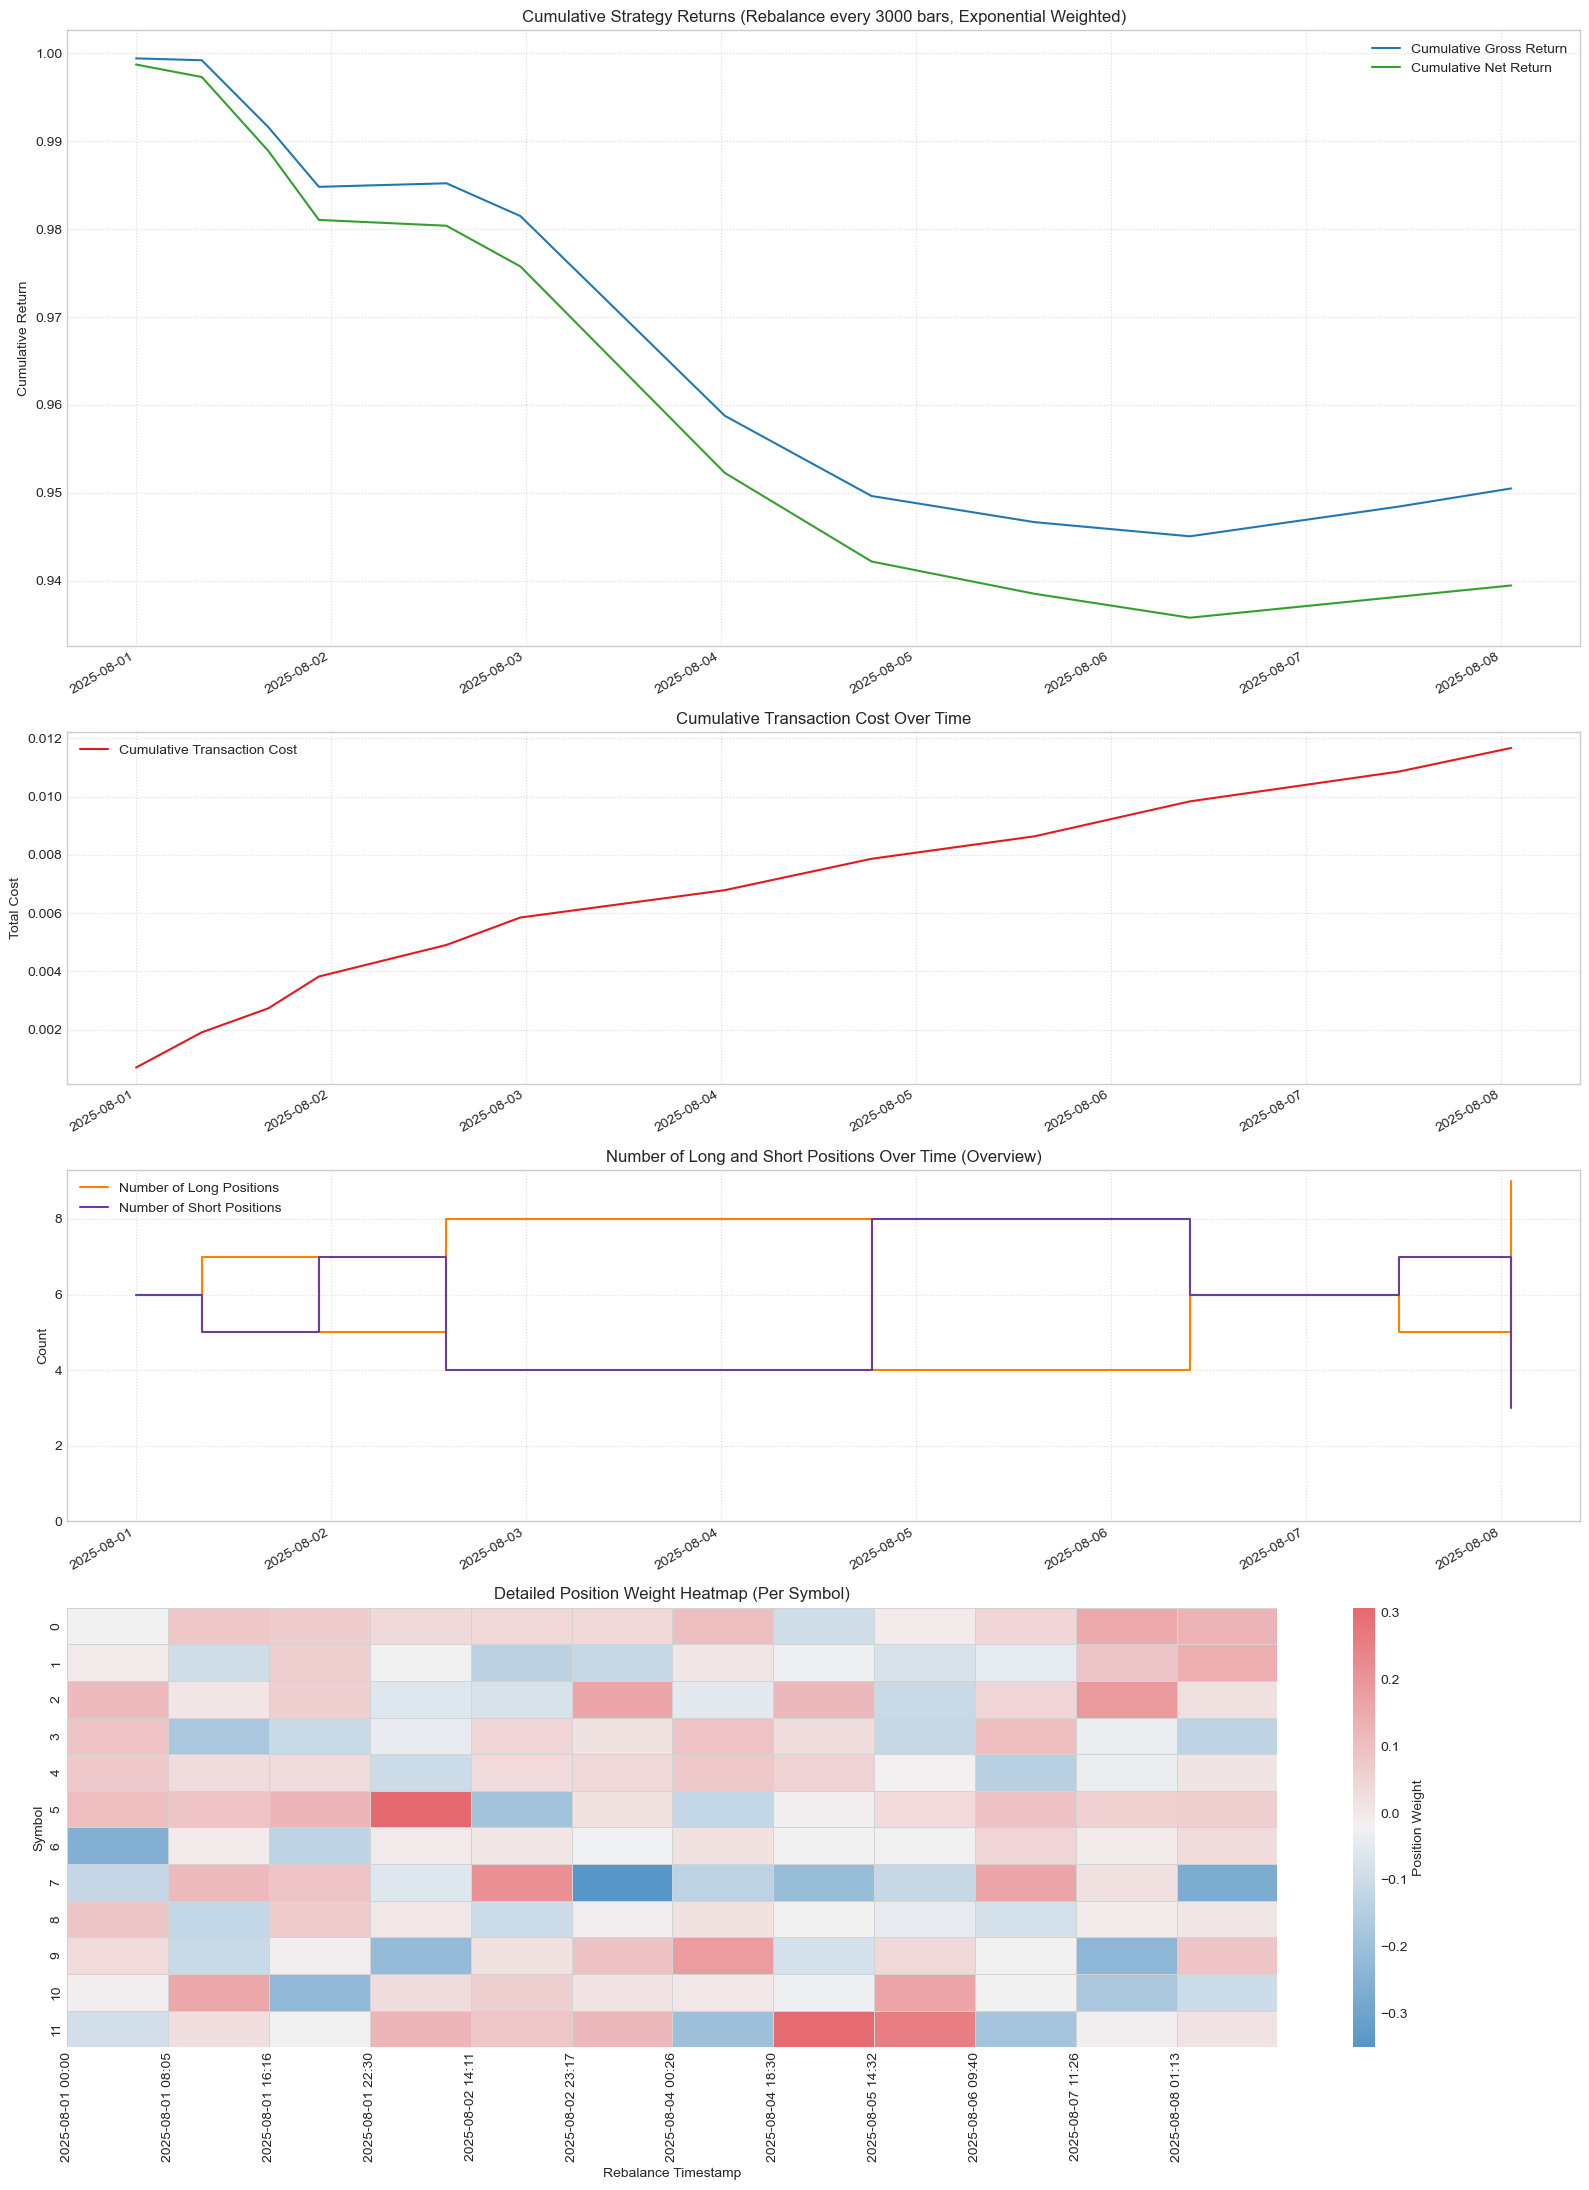

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns # 用于绘制热力图

# --- 假设 full_df 已经包含以下列 ---
# - 'timestamp'（时间戳，可转为 datetime）
# - 'symbol_enc'（币种编码）
# - 'px'（当期价格）
# - 'predicted_prob'（模型预测的概率，越大表示越好）

# --- 配置参数 ---
# 注意：你的原始代码中 bt_df = full_df，这里假设 full_df 已经被传入或定义
# 如果 full_df 是一个未定义的变量，你需要在这里定义或加载它
# 例如：bt_df = pd.read_csv('your_data.csv')
bt_df = full_df

# 这里N是一个未定义的变量，你需要给它一个具体的值，例如 100
# N = 100
N_INTERVAL = N * 1 # 调仓周期，每 N_INTERVAL 个时间戳调仓一次
TRANSACTION_COST_PER_TRADE = 0.0007 # 每单位交易的费用，这里是一个更通用的值

# 新增：单币种止损参数
STOP_LOSS_PERCENT = 0.15 # 单币种止损百分比，例如 0.15 表示 15% 的亏损止损

# ======================================================================
# ===== 权重计算函数 =====
# ======================================================================

n_beta = 5.0
def dollar_neutralize(weights):
    """
    保证多空资金平衡：多头资金=空头资金=0.5
    """
    long_sum = weights[weights > 0].sum()
    short_sum = -weights[weights < 0].sum()
    if long_sum == 0 or short_sum == 0:
        return weights / np.sum(np.abs(weights))
    w = weights.copy()
    w[w > 0] /= long_sum
    w[w < 0] /= short_sum
    return w / 2  # 多头合计=0.5，空头合计=-0.5

def exp_weights(scores, beta=5.0):
    """
    根据预测分数计算指数加权，并进行资金中性化
    """
    pos = np.exp(beta * np.clip(scores, 0, None))
    neg = -np.exp(beta * np.clip(-scores, 0, None))
    w = pos + neg
    return dollar_neutralize(w)

# --- 数据预处理 ---
bt_df['dt'] = pd.to_datetime(bt_df['timestamp'], unit='ms')
bt_df = bt_df.sort_values(['dt', 'symbol_enc']).reset_index(drop=True)
timestamps_sorted = bt_df['dt'].drop_duplicates().sort_values().to_list()
rebalance_times = timestamps_sorted[::N_INTERVAL]

# --- 识别多空信号（在每个调仓时间点）---
rebalance_weights = {}
for t in tqdm(rebalance_times, desc="Calculating Rebalance Weights"):
    current_snapshot = bt_df[bt_df['dt'] == t].copy()
    if current_snapshot.empty:
        rebalance_weights[t] = {}
        continue

    try:
        current_snapshot.set_index('symbol_enc', inplace=True)
        # 核心改动：使用 exp_weights
        weights = exp_weights(current_snapshot['predicted_prob'], beta=n_beta)
        rebalance_weights[t] = weights.to_dict()
    except Exception as e:
        print(f"Error calculating weights at {t}: {e}")
        rebalance_weights[t] = {}

# --- 构建调仓周期内的持仓和计算周期收益 ---
period_results = []
all_positions_by_period = []

current_weights = {} # {symbol: weight}

for i in tqdm(range(len(rebalance_times)), desc="Calculating Period Returns"):
    start_time = rebalance_times[i]
    end_time = rebalance_times[i+1] if i + 1 < len(rebalance_times) else timestamps_sorted[-1]

    # 获取当前周期的数据快照
    period_data = bt_df[(bt_df['dt'] >= start_time) & (bt_df['dt'] <= end_time)].copy()
    if period_data.empty:
        continue

    # 获取当前时间点（周期开始）的价格快照
    current_moment_prices = bt_df[bt_df['dt'] == start_time].set_index('symbol_enc')['px'].to_dict()

    # --- Step 1: 检查并处理单币种止损及联动调整 ---
    current_period_transaction_cost = 0.0
    long_positions_to_close = {}
    short_positions_to_close = {}

    # 遍历现有持仓检查止损
    for symbol, weight in list(current_weights.items()):
        open_px = current_moment_prices.get(symbol)
        if open_px is None or weight == 0:
            continue

        symbol_data = period_data[period_data['symbol_enc'] == symbol]
        if symbol_data.empty:
            continue
        
        # 简化处理：使用周期内最高/最低价判断是否触及止损
        min_px = symbol_data['px'].min()
        max_px = symbol_data['px'].max()

        triggered_stop_loss = False
        if weight > 0 and (open_px - min_px) / open_px >= STOP_LOSS_PERCENT: # 多头止损
            triggered_stop_loss = True
        elif weight < 0 and (max_px - open_px) / open_px >= STOP_LOSS_PERCENT: # 空头止损
            triggered_stop_loss = True
        
        if triggered_stop_loss:
            print(f"Stop-loss triggered for {symbol} ({'LONG' if weight > 0 else 'SHORT'}) at {start_time.strftime('%Y-%m-%d %H:%M')}.")
            
            if weight > 0:
                long_positions_to_close[symbol] = weight
            else:
                short_positions_to_close[symbol] = weight
            
            # 直接平仓，并将平仓费用计入
            current_weights[symbol] = 0.0
            current_period_transaction_cost += abs(weight) * TRANSACTION_COST_PER_TRADE

    # --- 联动调整剩余仓位以恢复资金中性 ---
    
    # 止损多头仓位，按比例减小所有空头仓位
    if long_positions_to_close:
        total_long_loss_weight = sum(long_positions_to_close.values())
        total_short_weight = -sum(w for w in current_weights.values() if w < 0)
        
        if total_short_weight > 0:
            adjustment_ratio = total_long_loss_weight / total_short_weight
            print(f"  -> Linkage: Adjusting short positions by ratio {adjustment_ratio:.2%}.")
            for symbol, weight in list(current_weights.items()):
                if weight < 0:
                    new_weight = weight * (1 - adjustment_ratio)
                    current_period_transaction_cost += abs(new_weight - weight) * TRANSACTION_COST_PER_TRADE
                    current_weights[symbol] = new_weight

    # 止损空头仓位，按比例减小所有多头仓位
    if short_positions_to_close:
        total_short_loss_weight = -sum(short_positions_to_close.values())
        total_long_weight = sum(w for w in current_weights.values() if w > 0)
        
        if total_long_weight > 0:
            adjustment_ratio = total_short_loss_weight / total_long_weight
            print(f"  -> Linkage: Adjusting long positions by ratio {adjustment_ratio:.2%}.")
            for symbol, weight in list(current_weights.items()):
                if weight > 0:
                    new_weight = weight * (1 - adjustment_ratio)
                    current_period_transaction_cost += abs(new_weight - weight) * TRANSACTION_COST_PER_TRADE
                    current_weights[symbol] = new_weight

    # --- Step 2: 根据调仓信号更新持仓并计算交易费用 ---
    # 获取本周期的目标权重
    target_weights = rebalance_weights.get(start_time, {})
    
    # 计算从当前持仓（已经过止损调整）到目标持仓的交易成本
    all_symbols = set(current_weights.keys()) | set(target_weights.keys())
    for symbol in all_symbols:
        old_weight = current_weights.get(symbol, 0)
        new_weight = target_weights.get(symbol, 0)
        current_period_transaction_cost += abs(new_weight - old_weight) * TRANSACTION_COST_PER_TRADE
    
    # 更新持仓权重
    current_weights = target_weights.copy()
    
    # --- Step 3: 计算本周期的策略收益 (毛收益) ---
    gross_period_log_return = 0.0
    if not current_weights:
        gross_period_log_return = 0.0
    else:
        end_prices = period_data[period_data['dt'] == end_time].set_index('symbol_enc')['px'].to_dict()
        start_prices = period_data[period_data['dt'] == start_time].set_index('symbol_enc')['px'].to_dict()
        
        for symbol, weight in current_weights.items():
            start_px = start_prices.get(symbol)
            end_px = end_prices.get(symbol)
            if start_px and end_px:
                log_return_per_symbol = np.log(end_px) - np.log(start_px)
                gross_period_log_return += weight * log_return_per_symbol
            
    net_period_log_return = gross_period_log_return - current_period_transaction_cost

    # --- 记录当前调仓周期所有品种的持仓状态 (用于热力图) ---
    all_unique_symbols = bt_df['symbol_enc'].unique()
    current_period_positions_for_heatmap = {symbol: 0.0 for symbol in all_unique_symbols}
    for symbol, weight in current_weights.items():
        current_period_positions_for_heatmap[symbol] = weight

    all_positions_by_period.append({'dt': start_time, **current_period_positions_for_heatmap})

    period_results.append({
        'dt': start_time,
        'gross_strategy_log_return': gross_period_log_return,
        'transaction_cost': current_period_transaction_cost, # 本周期总费用
        'net_strategy_log_return': net_period_log_return,
        'num_long_positions': sum(1 for w in current_weights.values() if w > 0),
        'num_short_positions': sum(1 for w in current_weights.values() if w < 0)
    })

# 将周期结果转换为 DataFrame
strategy_results_df = pd.DataFrame(period_results).set_index('dt')

# --- 准备持仓热力图数据 ---
positions_heatmap_df = pd.DataFrame(all_positions_by_period).set_index('dt')
positions_heatmap_df = positions_heatmap_df[sorted(positions_heatmap_df.columns)]


# --- 绩效指标函数 (与之前相同) ---
def perf_stats(return_series, periods_per_year):
    if return_series.empty:
        return {
            'Cumulative Return': np.nan, 'Annualized Return': np.nan,
            'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan, 'Max Drawdown': np.nan
        }

    cum_ret = return_series.cumsum().apply(np.exp)
    total_return = cum_ret.iloc[-1] - 1

    num_periods = len(return_series)
    if num_periods > 0:
        ann_return = (cum_ret.iloc[-1])**(periods_per_year / num_periods) - 1
    else:
        ann_return = np.nan

    ann_vol = return_series.std() * np.sqrt(periods_per_year)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    running_max = cum_ret.cummax()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'Cumulative Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }

# --- 计算和展示绩效 ---
periods_per_year_for_annualization = (365 * 24 * 60) / (N_INTERVAL * 10) # 假设10ms一个bar

print("\n--- Strategy Performance Statistics (Gross) ---")
gross_stats = perf_stats(strategy_results_df['gross_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(gross_stats))

print("\n--- Strategy Performance Statistics (Net of Costs) ---")
net_stats = perf_stats(strategy_results_df['net_strategy_log_return'], periods_per_year_for_annualization)
print(pd.Series(net_stats))

print(f"\nTotal Transaction Cost (Sum of individual costs): {strategy_results_df['transaction_cost'].sum():.6f}")

# --- 绘制图表 (使用低饱和度配色) ---
fig, axes = plt.subplots(4, 1, figsize=(16, 22), sharex=False, gridspec_kw={'height_ratios': [0.35, 0.2, 0.2, 0.25]})

# 定义低饱和度颜色
COLOR_GROSS_RETURN = sns.color_palette("Paired")[1]
COLOR_NET_RETURN = sns.color_palette("Paired")[3]
COLOR_TRANSACTION_COST = sns.color_palette("Paired")[5]
COLOR_LONG_POSITIONS = sns.color_palette("Paired")[7]
COLOR_SHORT_POSITIONS = sns.color_palette("Paired")[9]

# 热力图颜色映射 (低饱和度 RdBu)
HEATMAP_CMAP = sns.diverging_palette(240, 10, as_cmap=True, s=70, l=60, sep=1)

# 设置图表背景风格 (可选，例如设置为白色背景)
plt.style.use('seaborn-v0_8-whitegrid')

# 子图1: 累计收益 (毛收益 vs. 净收益)
strategy_results_df['gross_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Gross Return', color=COLOR_GROSS_RETURN)
strategy_results_df['net_strategy_log_return'].cumsum().apply(np.exp).plot(ax=axes[0], label='Cumulative Net Return', color=COLOR_NET_RETURN)
axes[0].set_title(f"Cumulative Strategy Returns (Rebalance every {N_INTERVAL} bars, Exponential Weighted)")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend()
axes[0].grid(True, linestyle=':', alpha=0.7)
axes[0].set_xlabel("")

# 子图2: 累计手续费消耗
strategy_results_df['transaction_cost'].cumsum().plot(ax=axes[1], label='Cumulative Transaction Cost', color=COLOR_TRANSACTION_COST)
axes[1].set_title("Cumulative Transaction Cost Over Time")
axes[1].set_ylabel("Total Cost")
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.7)
axes[1].set_xlabel("")

# 子图3: 持仓数量变化 (保留，作为快速概览)
strategy_results_df['num_long_positions'].plot(ax=axes[2], label='Number of Long Positions', color=COLOR_LONG_POSITIONS, drawstyle='steps-post')
strategy_results_df['num_short_positions'].plot(ax=axes[2], label='Number of Short Positions', color=COLOR_SHORT_POSITIONS, drawstyle='steps-post')
axes[2].set_title("Number of Long and Short Positions Over Time (Overview)")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("")
axes[2].legend()
axes[2].grid(True, linestyle=':', alpha=0.7)
axes[2].set_ylim(bottom=0)

# 子图4: 详细持仓热力图
if not positions_heatmap_df.empty:
    # 限制热力图只显示部分品种，避免图表过大
    unique_symbols = positions_heatmap_df.columns
    if len(unique_symbols) > 50:
        # 只显示前50个品种
        positions_heatmap_df_display = positions_heatmap_df.iloc[:, :50]
    else:
        positions_heatmap_df_display = positions_heatmap_df

    sns.heatmap(
        positions_heatmap_df_display.T,
        cmap=HEATMAP_CMAP,
        cbar_kws={'label': 'Position Weight'},
        ax=axes[3],
        yticklabels=True,
        xticklabels=True,
        linewidths=0.5,
        linecolor='lightgray'
    )
    axes[3].set_title("Detailed Position Weight Heatmap (Per Symbol)")
    axes[3].set_xlabel("Rebalance Timestamp")
    axes[3].set_ylabel("Symbol")
    
    # 调整x轴刻度标签，避免重叠
    num_ticks = 10 
    if len(positions_heatmap_df_display.index) > num_ticks:
        tick_interval = len(positions_heatmap_df_display.index) // num_ticks
        axes[3].set_xticks(np.arange(0, len(positions_heatmap_df_display.index), tick_interval))
        axes[3].set_xticklabels(positions_heatmap_df_display.index[::tick_interval].strftime('%Y-%m-%d %H:%M'))
    else:
        axes[3].set_xticklabels(positions_heatmap_df_display.index.strftime('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

In [48]:
import os
import json
import pickle
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

def save_tabnet_checkpoint(
    model,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None,
):
    if unique_id is None:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
        save_dir = os.path.join(base_save_dir, f"tabnet_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, unique_id)

    os.makedirs(save_dir, exist_ok=True)

    # 保存模型
    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    # 保存模型参数和元信息
    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    # 保存辅助对象
    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"✅ 模型和元信息已保存到: {save_dir}")


In [49]:
print(feature_cols, cat_idxs, cat_dims)
N_INTERVAL = N

['sum_buy_sz_zscaled', 'sum_sell_sz_zscaled', 'ts_duration_zscaled', 'bs_imbalance_zscaled', 'sum_open_interest_zscaled', 'raw_factor_oi_change_sum_zscaled', 'raw_factor_oi_change_sum_long_term_zscaled', 'raw_factor_short_term_oi_volatility_zscaled', 'raw_factor_long_term_oi_volatility_zscaled', 'raw_factor_short_term_oi_trend_zscaled', 'raw_factor_long_term_oi_trend_zscaled', 'raw_factor_sentiment_net_zscaled', 'z_factor_oi_change_zscaled', 'z_factor_oi_change_long_term_zscaled', 'z_factor_short_term_oi_volatility_zscaled', 'z_factor_long_term_oi_volatility_zscaled', 'z_factor_short_term_oi_trend_zscaled', 'z_factor_long_term_oi_trend_zscaled', 'z_factor_sentiment_net_zscaled', 'impact_price_pct_ask_imn_zscaled', 'impact_price_pct_bid_imn_zscaled', 'far_bid_price_zscaled', 'far_ask_price_zscaled', 'best_bid_price_zscaled', 'best_ask_price_zscaled', 'real_bid_amount_sum_zscaled', 'real_ask_amount_sum_zscaled', 'log1p_ts_velo_rol_mean_5000_zscaled', 'bid_px_gap_rol_mean_5000_zscaled', '

In [50]:
print(symbol_to_id.keys())
for sym, df in symbol_to_id.items():
    print(sym)
    print(df)

dict_keys([np.str_('ADAUSDT'), np.str_('ATOMUSDT'), np.str_('AVAXUSDT'), np.str_('BNBUSDT'), np.str_('BTCUSDT'), np.str_('DOGEUSDT'), np.str_('ETHUSDT'), np.str_('LTCUSDT'), np.str_('SOLUSDT'), np.str_('TONUSDT'), np.str_('UNIUSDT'), np.str_('XRPUSDT')])
ADAUSDT
0
ATOMUSDT
1
AVAXUSDT
2
BNBUSDT
3
BTCUSDT
4
DOGEUSDT
5
ETHUSDT
6
LTCUSDT
7
SOLUSDT
8
TONUSDT
9
UNIUSDT
10
XRPUSDT
11


In [51]:
# train_dfs = weekly_dataframes[-(n_train_weeks + n_val_weeks):-n_val_weeks]
# val_dfs = weekly_dataframes[-1]

# train_df = pl.concat(train_dfs)
# val_df = val_dfs

# X_train, y_train, px_train, ts_train, sb_train = process_df_np(train_df)
# X_val, y_val, px_val, ts_val, sb_val = process_df_np(val_df)

# print("=" * 60)
# print(f"Train {0}~{n_train_weeks}, Val {n_train_weeks+n_val_weeks}")
# print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
# print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])

# my_early_stopping = MinEpochsEarlyStopping(
#     early_stopping_metric='val_0_mae',
#     patience=3,
#     min_epochs=3,
# )

# tabnet = TabNetRegressor(**params )
# tabnet.fit(
#     X_train=X_train,
#     y_train=y_train,
#     eval_set=[(X_val, y_val)],
#     callbacks=[my_early_stopping], # 使用你的自定义回调
#     **init_fit_params,
# )



In [52]:
def convert_dict_np_to_builtin(d):
    return {str(k): int(v) for k, v in d.items()}

def convert_dict_keys_to_str_and_values_to_builtin(d):
    new_d = {}
    for k, v in d.items():
        # key 可能是 np.int64
        new_key = int(k) if isinstance(k, (np.integer,)) else str(k)
        # value 可能是 np.str_
        new_val = str(v) if isinstance(v, (np.str_,)) else v
        new_d[new_key] = new_val
    return new_d

In [53]:
a  =convert_dict_np_to_builtin(symbol_to_id)
print(a["BNBUSDT"])

3


In [54]:
b = convert_dict_keys_to_str_and_values_to_builtin(id_to_symbol)
print(b)

{0: 'ADAUSDT', 1: 'ATOMUSDT', 2: 'AVAXUSDT', 3: 'BNBUSDT', 4: 'BTCUSDT', 5: 'DOGEUSDT', 6: 'ETHUSDT', 7: 'LTCUSDT', 8: 'SOLUSDT', 9: 'TONUSDT', 10: 'UNIUSDT', 11: 'XRPUSDT'}


In [55]:
   
# save_tabnet_checkpoint(
#     model=tabnet,
#     base_save_dir="./saved_models/tabnet_crosec",
#     model_params=params,
#     feature_names=feature_cols,
#     training_meta={
#         "symbol_to_id": convert_dict_np_to_builtin(symbol_to_id),
#         "id_to_symbol": convert_dict_keys_to_str_and_values_to_builtin(id_to_symbol),
#         "train_n_week": n_train_weeks,
#         "fit_params": init_fit_params,
#         "label_window": N,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "feat_cal_window": int(feat_cal_window),
#         "feat_norm_window": feat_norm_window,
#         "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
#         "n_interval": N_INTERVAL,
#         "n_beta": n_beta,
#         "sl_percent": STOP_LOSS_PERCENT,
#     },
# )